**3 Edge Servers and 3 Clients/Server**

In [ ]:
pip install plotly

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from cryptography.hazmat.primitives.asymmetric import x25519
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers.aead import ChaCha20Poly1305
from cryptography.hazmat.backends import default_backend
import os
import pickle
from collections import defaultdict
import statistics
import plotly.graph_objects as go  # Added for interactive plotting

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Simulation parameters
NUM_EDGE_SERVERS = 3
CLIENTS_PER_EDGE = 3
TOTAL_CLIENTS = NUM_EDGE_SERVERS * CLIENTS_PER_EDGE
TOTAL_ROUNDS = 50
BATCH_SIZE = 64
CLIENT_EPOCHS = 3
EDGE_EPOCHS = 1
LEARNING_RATE = 0.01

# Security parameters
MODEL_ENCRYPTION_INFO = b'model_encryption_v1'
HMAC_KEY_INFO = b'model_hmac_key_v1'

# Network latency parameters (in milliseconds)
BASE_CLIENT_TO_EDGE_LATENCY = 10  # Base network latency without crypto
BASE_EDGE_TO_CLOUD_LATENCY = 15    # Base network latency without crypto

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SecurityBenchmark:
    @staticmethod
    def benchmark_crypto_operations():
        """Benchmark cryptographic operations for single model update"""
        results = {}

        # Generate test data
        dummy_model = MNISTModel().to(device)
        model_state = dummy_model.state_dict()
        serialized_model = pickle.dumps(model_state)

        # Key generation benchmark
        start = time.time()
        private_key = x25519.X25519PrivateKey.generate()
        public_key = private_key.public_key()
        results['keygen_time'] = (time.time() - start) * 1000  # ms

        # Key exchange benchmark
        peer_private = x25519.X25519PrivateKey.generate()
        peer_public = peer_private.public_key()
        start = time.time()
        shared_secret = private_key.exchange(peer_public)
        results['key_exchange_time'] = (time.time() - start) * 1000

        # Key derivation benchmark
        start = time.time()
        enc_key = HKDF(
            algorithm=hashes.BLAKE2b(64),
            length=32,
            salt=None,
            info=MODEL_ENCRYPTION_INFO,
            backend=default_backend()
        ).derive(shared_secret)
        results['key_derivation_time'] = (time.time() - start) * 1000

        # Encryption benchmark
        chacha = ChaCha20Poly1305(enc_key)
        nonce = os.urandom(12)
        start = time.time()
        ciphertext = chacha.encrypt(nonce, serialized_model, None)
        results['encryption_time'] = (time.time() - start) * 1000

        # Decryption benchmark
        start = time.time()
        chacha.decrypt(nonce, ciphertext, None)
        results['decryption_time'] = (time.time() - start) * 1000

        # Calculate message expansion
        original_size = len(serialized_model)
        encrypted_size = len(nonce) + len(ciphertext)
        results['message_expansion'] = encrypted_size - original_size

        return results

class LightweightCrypto:
    @staticmethod
    def generate_keys():
        private_key = x25519.X25519PrivateKey.generate()
        public_key = private_key.public_key()
        return private_key, public_key

    @staticmethod
    def generate_shared_secret(private_key, peer_public_key):
        return private_key.exchange(peer_public_key)

    @staticmethod
    def derive_keys(shared_secret, info, length=32):
        return HKDF(
            algorithm=hashes.BLAKE2b(64),
            length=length,
            salt=None,
            info=info,
            backend=default_backend()
        ).derive(shared_secret)

    @staticmethod
    def encrypt_model(key, model_state_dict):
        chacha = ChaCha20Poly1305(key)
        nonce = os.urandom(12)
        serialized_model = pickle.dumps(model_state_dict)
        ciphertext = chacha.encrypt(nonce, serialized_model, None)
        return nonce + ciphertext

    @staticmethod
    def decrypt_model(key, encrypted_data):
        chacha = ChaCha20Poly1305(key)
        nonce = encrypted_data[:12]
        ciphertext = encrypted_data[12:]
        serialized_model = chacha.decrypt(nonce, ciphertext, None)
        return pickle.loads(serialized_model)

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def load_and_partition_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    client_datasets = []
    labels = train_dataset.targets.numpy()

    for i in range(TOTAL_CLIENTS):
        indices = []
        for class_id in range(10):
            class_indices = np.where(labels == class_id)[0]
            start = (i * len(class_indices)) // TOTAL_CLIENTS
            end = ((i + 1) * len(class_indices)) // TOTAL_CLIENTS
            indices.extend(class_indices[start:end])
        client_dataset = Subset(train_dataset, indices)
        client_datasets.append(client_dataset)

    edge_test_datasets = []
    test_labels = test_dataset.targets.numpy()
    for i in range(NUM_EDGE_SERVERS):
        indices = []
        for class_id in range(10):
            class_indices = np.where(test_labels == class_id)[0]
            start = (i * len(class_indices)) // NUM_EDGE_SERVERS
            end = ((i + 1) * len(class_indices)) // NUM_EDGE_SERVERS
            indices.extend(class_indices[start:end])
        edge_test_dataset = Subset(test_dataset, indices)
        edge_test_datasets.append(edge_test_dataset)

    return client_datasets, edge_test_datasets, test_dataset

def secure_client_update(model, dataset, epochs, lr, encryption_key):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    # Time encryption
    enc_start = time.time()
    encrypted_model = LightweightCrypto.encrypt_model(encryption_key, model.state_dict())
    enc_time = (time.time() - enc_start) * 1000

    return encrypted_model, enc_time

def secure_edge_aggregate(encrypted_models, decryption_key):
    decrypted_weights = []
    dec_times = []

    for enc_model in encrypted_models:
        try:
            dec_start = time.time()
            weights = LightweightCrypto.decrypt_model(decryption_key, enc_model)
            dec_time = (time.time() - dec_start) * 1000
            decrypted_weights.append(weights)
            dec_times.append(dec_time)
        except:
            #print("Decryption failed - skipping corrupted model update")
            continue

    if not decrypted_weights:
        return None, 0

    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).mean(0)

    return avg_weights, statistics.mean(dec_times)

def secure_cloud_aggregate(encrypted_edge_updates, decryption_keys):
    decrypted_weights = []
    dec_times = []

    for enc_update, key in zip(encrypted_edge_updates, decryption_keys):
        try:
            dec_start = time.time()
            weights = LightweightCrypto.decrypt_model(key, enc_update)
            dec_time = (time.time() - dec_start) * 1000
            decrypted_weights.append(weights)
            dec_times.append(dec_time)
        except:
            print("Edge decryption failed - skipping corrupted edge update")
            continue

    if not decrypted_weights:
        return None, 0

    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).mean(0)

    return avg_weights, statistics.mean(dec_times)

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())

    test_loss /= len(test_loader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    return test_loss, accuracy, precision, recall, f1

def simulate_secure_two_stage_fl():
    # Benchmark cryptographic operations first
    crypto_benchmark = SecurityBenchmark.benchmark_crypto_operations()
    print("\nCryptographic Operations Benchmark (single operation):")
    for k, v in crypto_benchmark.items():
        print(f"{k.replace('_', ' ').title():<25}: {v:.4f} {'ms' if 'time' in k else 'bytes'}")

    # Load and partition data
    client_datasets, edge_test_datasets, global_test_dataset = load_and_partition_mnist()
    global_test_loader = DataLoader(global_test_dataset, batch_size=BATCH_SIZE)

    # Initialize models
    global_model = MNISTModel().to(device)
    edge_models = [MNISTModel().to(device) for _ in range(NUM_EDGE_SERVERS)]
    client_models = [MNISTModel().to(device) for _ in range(TOTAL_CLIENTS)]

    # Initialize cryptographic keys
    cloud_private, cloud_public = LightweightCrypto.generate_keys()
    edge_keys = [LightweightCrypto.generate_keys() for _ in range(NUM_EDGE_SERVERS)]
    client_keys = [LightweightCrypto.generate_keys() for _ in range(TOTAL_CLIENTS)]

    # Establish shared secrets
    client_edge_secrets = defaultdict(dict)
    for edge_idx in range(NUM_EDGE_SERVERS):
        edge_private, edge_public = edge_keys[edge_idx]
        for client_idx in range(edge_idx * CLIENTS_PER_EDGE, (edge_idx + 1) * CLIENTS_PER_EDGE):
            client_private, client_public = client_keys[client_idx]
            shared_secret = LightweightCrypto.generate_shared_secret(client_private, edge_public)
            enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
            client_edge_secrets[edge_idx][client_idx] = enc_key

    edge_cloud_secrets = []
    for edge_idx in range(NUM_EDGE_SERVERS):
        edge_private, _ = edge_keys[edge_idx]
        shared_secret = LightweightCrypto.generate_shared_secret(edge_private, cloud_public)
        enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
        edge_cloud_secrets.append(enc_key)

    # Enhanced metrics tracking with new timing metrics
    metrics = {
        'round': [],
        'global_accuracy': [], 'global_precision': [], 'global_recall': [], 'global_f1': [],
        'client_edge_latencies': [], 'edge_cloud_latencies': [],
        'client_to_edge_comm': [], 'edge_to_cloud_comm': [],
        'client_enc_times': [], 'edge_dec_times': [], 'edge_enc_times': [], 'cloud_dec_times': [],
        'client_train_times': [],  # New: Local training time per client
        'edge_agg_times': [],     # New: Edge aggregation time
        'cloud_agg_times': []      # New: Cloud aggregation time
    }

    # Calculate model size
    dummy_model = MNISTModel().to(device)
    model_size_bytes = sum(p.numel() * 4 for p in dummy_model.parameters())
    encrypted_size = model_size_bytes + 12 + 16  # Model + nonce + tag

    # Main training loop
    for round_num in range(TOTAL_ROUNDS):
        print(f"\n=== Round {round_num + 1}/{TOTAL_ROUNDS} ===")
        round_metrics = {
            'client_edge_latencies': [],
            'edge_cloud_latencies': [],
            'client_train_times': [],
            'edge_agg_times': [],
            'cloud_agg_times': []
        }

        # Edge-level processing
        edge_updates = []

        for edge_idx in range(NUM_EDGE_SERVERS):
            client_indices = range(edge_idx * CLIENTS_PER_EDGE, (edge_idx + 1) * CLIENTS_PER_EDGE)
            encrypted_client_updates = []

            # Client updates
            for client_idx in client_indices:
                # Measure total client-edge transmission time
                trans_start = time.time()

                client_models[client_idx].load_state_dict(edge_models[edge_idx].state_dict())
                enc_key = client_edge_secrets[edge_idx][client_idx]

                # Client update with encryption timing
                train_start = time.time()
                encrypted_update, enc_time = secure_client_update(
                    client_models[client_idx],
                    client_datasets[client_idx],
                    CLIENT_EPOCHS,
                    LEARNING_RATE,
                    enc_key
                )
                train_time = (time.time() - train_start) * 1000
                round_metrics['client_train_times'].append(train_time)

                # Simulate network transmission
                time.sleep(BASE_CLIENT_TO_EDGE_LATENCY / 1000)

                trans_time = (time.time() - trans_start) * 1000
                round_metrics['client_edge_latencies'].append(trans_time)
                metrics['client_enc_times'].append(enc_time)
                metrics['client_to_edge_comm'].append(encrypted_size)

                encrypted_client_updates.append(encrypted_update)

            # Edge aggregation with decryption timing
            agg_start = time.time()
            edge_weights, avg_dec_time = secure_edge_aggregate(
                encrypted_client_updates,
                client_edge_secrets[edge_idx][client_indices[0]]
            )
            agg_time = (time.time() - agg_start) * 1000
            round_metrics['edge_agg_times'].append(agg_time)
            metrics['edge_dec_times'].append(avg_dec_time)

            if edge_weights is None:
                edge_updates.append(None)
                continue

            edge_models[edge_idx].load_state_dict(edge_weights)

            # Optional edge training
            if EDGE_EPOCHS > 0:
                edge_loader = DataLoader(client_datasets[client_indices[0]], batch_size=BATCH_SIZE)
                optimizer = torch.optim.SGD(edge_models[edge_idx].parameters(), lr=LEARNING_RATE)
                for _ in range(EDGE_EPOCHS):
                    for data, target in edge_loader:
                        data, target = data.to(device), target.to(device)
                        optimizer.zero_grad()
                        output = edge_models[edge_idx](data)
                        loss = F.nll_loss(output, target)
                        loss.backward()
                        optimizer.step()

            # Edge-cloud transmission with timing
            trans_start = time.time()
            enc_start = time.time()
            encrypted_edge_update = LightweightCrypto.encrypt_model(
                edge_cloud_secrets[edge_idx],
                edge_models[edge_idx].state_dict()
            )
            enc_time = (time.time() - enc_start) * 1000
            metrics['edge_enc_times'].append(enc_time)

            # Simulate network transmission
            time.sleep(BASE_EDGE_TO_CLOUD_LATENCY / 1000)

            trans_time = (time.time() - trans_start) * 1000
            round_metrics['edge_cloud_latencies'].append(trans_time)
            metrics['edge_to_cloud_comm'].append(encrypted_size)

            edge_updates.append(encrypted_edge_update)

            # Evaluate edge model
            edge_test_loader = DataLoader(edge_test_datasets[edge_idx], batch_size=BATCH_SIZE)
            _, edge_acc, edge_prec, edge_rec, edge_f1 = evaluate(edge_models[edge_idx], edge_test_loader)
            print(f"Edge {edge_idx} - Acc: {edge_acc:.4f}, Prec: {edge_prec:.4f}, Rec: {edge_rec:.4f}, F1: {edge_f1:.4f}")

        # Cloud aggregation with decryption timing
        agg_start = time.time()
        global_weights, avg_dec_time = secure_cloud_aggregate(
            [update for update in edge_updates if update is not None],
            edge_cloud_secrets
        )
        agg_time = (time.time() - agg_start) * 1000
        round_metrics['cloud_agg_times'].append(agg_time)
        metrics['cloud_dec_times'].append(avg_dec_time)

        if global_weights is not None:
            global_model.load_state_dict(global_weights)
            # Distribute global model back to edge servers
            for edge_idx in range(NUM_EDGE_SERVERS):
                if edge_updates[edge_idx] is not None:
                    edge_models[edge_idx].load_state_dict(global_model.state_dict())

        # Evaluate global model
        _, global_acc, global_prec, global_rec, global_f1 = evaluate(global_model, global_test_loader)
        print(f"Global - Acc: {global_acc:.4f}, Prec: {global_prec:.4f}, Rec: {global_rec:.4f}, F1: {global_f1:.4f}")

        # Record metrics
        metrics['round'].append(round_num + 1)
        metrics['global_accuracy'].append(global_acc)
        metrics['global_precision'].append(global_prec)
        metrics['global_recall'].append(global_rec)
        metrics['global_f1'].append(global_f1)
        metrics['client_edge_latencies'].extend(round_metrics['client_edge_latencies'])
        metrics['edge_cloud_latencies'].extend(round_metrics['edge_cloud_latencies'])
        metrics['client_train_times'].extend(round_metrics['client_train_times'])
        metrics['edge_agg_times'].extend(round_metrics['edge_agg_times'])
        metrics['cloud_agg_times'].extend(round_metrics['cloud_agg_times'])

    return metrics, crypto_benchmark

def plot_metrics(metrics):
    # Create interactive global accuracy plot
    fig = go.Figure()

    # Global accuracy plot with round markers
    fig.add_trace(go.Scatter(
        x=metrics['round'],
        y=metrics['global_accuracy'],
        mode='lines+markers',
        name='Global Accuracy',
        marker=dict(
            size=10,
            symbol='circle',
            line=dict(width=2)
        )
    ))

    fig.update_layout(
        title='Global Model Accuracy Across Rounds',
        xaxis_title='Round',
        yaxis_title='Accuracy',
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(showgrid=True, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridcolor='lightgray'),
        hovermode='x unified'
    )

    fig.show()





def print_final_report(metrics, crypto_benchmark):
    print("\n=== FINAL PERFORMANCE REPORT ===")

    # Model performance
    print("\n[1] Model Performance Metrics:")
    print(f"Final Accuracy:    {metrics['global_accuracy'][-1]:.4f}")
    print(f"Final Precision:   {metrics['global_precision'][-1]:.4f}")
    print(f"Final Recall:      {metrics['global_recall'][-1]:.4f}")
    print(f"Final F1 Score:    {metrics['global_f1'][-1]:.4f}")

    # Timing metrics
    print("\n[2] Computation Times:")
    print(f"Avg Client Training Time:    {np.mean(metrics['client_train_times']):.2f} ± {np.std(metrics['client_train_times']):.2f} ms")
    print(f"Avg Edge Aggregation Time:   {np.mean(metrics['edge_agg_times']):.2f} ± {np.std(metrics['edge_agg_times']):.2f} ms")
    print(f"Avg Cloud Aggregation Time:  {np.mean(metrics['cloud_agg_times']):.2f} ± {np.std(metrics['cloud_agg_times']):.2f} ms")

    # Latency analysis
    print("\n[3] Transmission Latencies:")
    print(f"Avg Client-to-Edge Latency: {np.mean(metrics['client_edge_latencies']):.2f} ± {np.std(metrics['client_edge_latencies']):.2f} ms")
    print(f"Avg Edge-to-Cloud Latency:  {np.mean(metrics['edge_cloud_latencies']):.2f} ± {np.std(metrics['edge_cloud_latencies']):.2f} ms")
    print(f"Base Network Latency Only:  Client-Edge: {BASE_CLIENT_TO_EDGE_LATENCY} ms, Edge-Cloud: {BASE_EDGE_TO_CLOUD_LATENCY} ms")

    # Communication overhead
    print("\n[4] Communication Overhead:")
    total_client_edge = sum(metrics['client_to_edge_comm']) / (1024*1024)
    total_edge_cloud = sum(metrics['edge_to_cloud_comm']) / (1024*1024)
    print(f"Total Client-to-Edge Data: {total_client_edge:.2f} MB")
    print(f"Total Edge-to-Cloud Data: {total_edge_cloud:.2f} MB")
    print(f"Total Communication: {total_client_edge + total_edge_cloud:.2f} MB")

    # Cryptographic performance
    print("\n[5] Cryptographic Performance:")
    print("\nSingle Operation Benchmarks:")
    for k, v in crypto_benchmark.items():
        print(f"{k.replace('_', ' ').title():<25}: {v:.4f} {'ms' if 'time' in k else 'bytes'}")

    print("\nOperational Averages During FL:")
    print(f"Client Encryption:  {np.mean(metrics['client_enc_times']):.4f} ms")
    print(f"Edge Decryption:    {np.mean(metrics['edge_dec_times']):.4f} ms")
    print(f"Edge Encryption:    {np.mean(metrics['edge_enc_times']):.4f} ms")
    print(f"Cloud Decryption:   {np.mean(metrics['cloud_dec_times']):.4f} ms")

    # Security overhead analysis
    crypto_overhead = (np.mean(metrics['client_enc_times']) + np.mean(metrics['edge_dec_times']) +
                     np.mean(metrics['edge_enc_times']) + np.mean(metrics['cloud_dec_times']))
    network_overhead = crypto_benchmark['message_expansion'] * (len(metrics['client_to_edge_comm']) +
                                                             len(metrics['edge_to_cloud_comm']))
    print(f"\nTotal Crypto Time Overhead: {crypto_overhead:.4f} ms per round")
    print(f"Total Network Overhead:    {network_overhead / (1024*1024):.4f} MB")

def main():
    metrics, crypto_benchmark = simulate_secure_two_stage_fl()
    plot_metrics(metrics)
    print_final_report(metrics, crypto_benchmark)

if __name__ == "__main__":
    main()


Cryptographic Operations Benchmark (single operation):
Keygen Time              : 0.1690 ms
Key Exchange Time        : 0.0582 ms
Key Derivation Time      : 0.0718 ms
Encryption Time          : 3.1292 ms
Decryption Time          : 5.0685 ms
Message Expansion        : 28.0000 bytes

=== Round 1/50 ===
Decryption failed - skipping corrupted model update
Decryption failed - skipping corrupted model update
Edge 0 - Acc: 0.2112, Prec: 0.5060, Rec: 0.2108, F1: 0.1864
Decryption failed - skipping corrupted model update
Decryption failed - skipping corrupted model update
Edge 1 - Acc: 0.3126, Prec: 0.6422, Rec: 0.3109, F1: 0.3220
Decryption failed - skipping corrupted model update
Decryption failed - skipping corrupted model update
Edge 2 - Acc: 0.2424, Prec: 0.6732, Rec: 0.2439, F1: 0.2353
Global - Acc: 0.1948, Prec: 0.4468, Rec: 0.1975, F1: 0.1629

=== Round 2/50 ===
Decryption failed - skipping corrupted model update
Decryption failed - skipping corrupted model update
Edge 0 - Acc: 0.4233, 


=== FINAL PERFORMANCE REPORT ===

[1] Model Performance Metrics:
Final Accuracy:    0.9808
Final Precision:   0.9807
Final Recall:      0.9808
Final F1 Score:    0.9807

[2] Computation Times:
Avg Client Training Time:    4317.70 ± 27.87 ms
Avg Edge Aggregation Time:   17.93 ± 1.11 ms
Avg Cloud Aggregation Time:  33.19 ± 3.89 ms

[3] Transmission Latencies:
Avg Client-to-Edge Latency: 4328.22 ± 27.87 ms
Avg Edge-to-Cloud Latency:  25.22 ± 1.59 ms
Base Network Latency Only:  Client-Edge: 10 ms, Edge-Cloud: 15 ms

[4] Communication Overhead:
Total Client-to-Edge Data: 2059.75 MB
Total Edge-to-Cloud Data: 686.58 MB
Total Communication: 2746.33 MB

[5] Cryptographic Performance:

Single Operation Benchmarks:
Keygen Time              : 0.1690 ms
Key Exchange Time        : 0.0582 ms
Key Derivation Time      : 0.0718 ms
Encryption Time          : 3.1292 ms
Decryption Time          : 5.0685 ms
Message Expansion        : 28.0000 bytes

Operational Averages During FL:
Client Encryption:  8.7496

**5 Edge Servers and 5 Clients/Server**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from cryptography.hazmat.primitives.asymmetric import x25519
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers.aead import ChaCha20Poly1305
from cryptography.hazmat.backends import default_backend
import os
import pickle
from collections import defaultdict
import statistics
import plotly.graph_objects as go  # Added for interactive plotting

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Simulation parameters
NUM_EDGE_SERVERS = 5
CLIENTS_PER_EDGE = 5
TOTAL_CLIENTS = NUM_EDGE_SERVERS * CLIENTS_PER_EDGE
TOTAL_ROUNDS = 50
BATCH_SIZE = 64
CLIENT_EPOCHS = 3
EDGE_EPOCHS = 1
LEARNING_RATE = 0.01

# Security parameters
MODEL_ENCRYPTION_INFO = b'model_encryption_v1'
HMAC_KEY_INFO = b'model_hmac_key_v1'

# Network latency parameters (in milliseconds)
BASE_CLIENT_TO_EDGE_LATENCY = 10  # Base network latency without crypto
BASE_EDGE_TO_CLOUD_LATENCY = 15    # Base network latency without crypto

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SecurityBenchmark:
    @staticmethod
    def benchmark_crypto_operations():
        """Benchmark cryptographic operations for single model update"""
        results = {}

        # Generate test data
        dummy_model = MNISTModel().to(device)
        model_state = dummy_model.state_dict()
        serialized_model = pickle.dumps(model_state)

        # Key generation benchmark
        start = time.time()
        private_key = x25519.X25519PrivateKey.generate()
        public_key = private_key.public_key()
        results['keygen_time'] = (time.time() - start) * 1000  # ms

        # Key exchange benchmark
        peer_private = x25519.X25519PrivateKey.generate()
        peer_public = peer_private.public_key()
        start = time.time()
        shared_secret = private_key.exchange(peer_public)
        results['key_exchange_time'] = (time.time() - start) * 1000

        # Key derivation benchmark
        start = time.time()
        enc_key = HKDF(
            algorithm=hashes.BLAKE2b(64),
            length=32,
            salt=None,
            info=MODEL_ENCRYPTION_INFO,
            backend=default_backend()
        ).derive(shared_secret)
        results['key_derivation_time'] = (time.time() - start) * 1000

        # Encryption benchmark
        chacha = ChaCha20Poly1305(enc_key)
        nonce = os.urandom(12)
        start = time.time()
        ciphertext = chacha.encrypt(nonce, serialized_model, None)
        results['encryption_time'] = (time.time() - start) * 1000

        # Decryption benchmark
        start = time.time()
        chacha.decrypt(nonce, ciphertext, None)
        results['decryption_time'] = (time.time() - start) * 1000

        # Calculate message expansion
        original_size = len(serialized_model)
        encrypted_size = len(nonce) + len(ciphertext)
        results['message_expansion'] = encrypted_size - original_size

        return results

class LightweightCrypto:
    @staticmethod
    def generate_keys():
        private_key = x25519.X25519PrivateKey.generate()
        public_key = private_key.public_key()
        return private_key, public_key

    @staticmethod
    def generate_shared_secret(private_key, peer_public_key):
        return private_key.exchange(peer_public_key)

    @staticmethod
    def derive_keys(shared_secret, info, length=32):
        return HKDF(
            algorithm=hashes.BLAKE2b(64),
            length=length,
            salt=None,
            info=info,
            backend=default_backend()
        ).derive(shared_secret)

    @staticmethod
    def encrypt_model(key, model_state_dict):
        chacha = ChaCha20Poly1305(key)
        nonce = os.urandom(12)
        serialized_model = pickle.dumps(model_state_dict)
        ciphertext = chacha.encrypt(nonce, serialized_model, None)
        return nonce + ciphertext

    @staticmethod
    def decrypt_model(key, encrypted_data):
        chacha = ChaCha20Poly1305(key)
        nonce = encrypted_data[:12]
        ciphertext = encrypted_data[12:]
        serialized_model = chacha.decrypt(nonce, ciphertext, None)
        return pickle.loads(serialized_model)

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def load_and_partition_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    client_datasets = []
    labels = train_dataset.targets.numpy()

    for i in range(TOTAL_CLIENTS):
        indices = []
        for class_id in range(10):
            class_indices = np.where(labels == class_id)[0]
            start = (i * len(class_indices)) // TOTAL_CLIENTS
            end = ((i + 1) * len(class_indices)) // TOTAL_CLIENTS
            indices.extend(class_indices[start:end])
        client_dataset = Subset(train_dataset, indices)
        client_datasets.append(client_dataset)

    edge_test_datasets = []
    test_labels = test_dataset.targets.numpy()
    for i in range(NUM_EDGE_SERVERS):
        indices = []
        for class_id in range(10):
            class_indices = np.where(test_labels == class_id)[0]
            start = (i * len(class_indices)) // NUM_EDGE_SERVERS
            end = ((i + 1) * len(class_indices)) // NUM_EDGE_SERVERS
            indices.extend(class_indices[start:end])
        edge_test_dataset = Subset(test_dataset, indices)
        edge_test_datasets.append(edge_test_dataset)

    return client_datasets, edge_test_datasets, test_dataset

def secure_client_update(model, dataset, epochs, lr, encryption_key):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    # Time encryption
    enc_start = time.time()
    encrypted_model = LightweightCrypto.encrypt_model(encryption_key, model.state_dict())
    enc_time = (time.time() - enc_start) * 1000

    return encrypted_model, enc_time

def secure_edge_aggregate(encrypted_models, decryption_key):
    decrypted_weights = []
    dec_times = []

    for enc_model in encrypted_models:
        try:
            dec_start = time.time()
            weights = LightweightCrypto.decrypt_model(decryption_key, enc_model)
            dec_time = (time.time() - dec_start) * 1000
            decrypted_weights.append(weights)
            dec_times.append(dec_time)
        except:
            #print("Decryption failed - skipping corrupted model update")
            continue

    if not decrypted_weights:
        return None, 0

    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).mean(0)

    return avg_weights, statistics.mean(dec_times)

def secure_cloud_aggregate(encrypted_edge_updates, decryption_keys):
    decrypted_weights = []
    dec_times = []

    for enc_update, key in zip(encrypted_edge_updates, decryption_keys):
        try:
            dec_start = time.time()
            weights = LightweightCrypto.decrypt_model(key, enc_update)
            dec_time = (time.time() - dec_start) * 1000
            decrypted_weights.append(weights)
            dec_times.append(dec_time)
        except:
            print("Edge decryption failed - skipping corrupted edge update")
            continue

    if not decrypted_weights:
        return None, 0

    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).mean(0)

    return avg_weights, statistics.mean(dec_times)

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())

    test_loss /= len(test_loader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    return test_loss, accuracy, precision, recall, f1

def simulate_secure_two_stage_fl():
    # Benchmark cryptographic operations first
    crypto_benchmark = SecurityBenchmark.benchmark_crypto_operations()
    print("\nCryptographic Operations Benchmark (single operation):")
    for k, v in crypto_benchmark.items():
        print(f"{k.replace('_', ' ').title():<25}: {v:.4f} {'ms' if 'time' in k else 'bytes'}")

    # Load and partition data
    client_datasets, edge_test_datasets, global_test_dataset = load_and_partition_mnist()
    global_test_loader = DataLoader(global_test_dataset, batch_size=BATCH_SIZE)

    # Initialize models
    global_model = MNISTModel().to(device)
    edge_models = [MNISTModel().to(device) for _ in range(NUM_EDGE_SERVERS)]
    client_models = [MNISTModel().to(device) for _ in range(TOTAL_CLIENTS)]

    # Initialize cryptographic keys
    cloud_private, cloud_public = LightweightCrypto.generate_keys()
    edge_keys = [LightweightCrypto.generate_keys() for _ in range(NUM_EDGE_SERVERS)]
    client_keys = [LightweightCrypto.generate_keys() for _ in range(TOTAL_CLIENTS)]

    # Establish shared secrets
    client_edge_secrets = defaultdict(dict)
    for edge_idx in range(NUM_EDGE_SERVERS):
        edge_private, edge_public = edge_keys[edge_idx]
        for client_idx in range(edge_idx * CLIENTS_PER_EDGE, (edge_idx + 1) * CLIENTS_PER_EDGE):
            client_private, client_public = client_keys[client_idx]
            shared_secret = LightweightCrypto.generate_shared_secret(client_private, edge_public)
            enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
            client_edge_secrets[edge_idx][client_idx] = enc_key

    edge_cloud_secrets = []
    for edge_idx in range(NUM_EDGE_SERVERS):
        edge_private, _ = edge_keys[edge_idx]
        shared_secret = LightweightCrypto.generate_shared_secret(edge_private, cloud_public)
        enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
        edge_cloud_secrets.append(enc_key)

    # Enhanced metrics tracking with new timing metrics
    metrics = {
        'round': [],
        'global_accuracy': [], 'global_precision': [], 'global_recall': [], 'global_f1': [],
        'client_edge_latencies': [], 'edge_cloud_latencies': [],
        'client_to_edge_comm': [], 'edge_to_cloud_comm': [],
        'client_enc_times': [], 'edge_dec_times': [], 'edge_enc_times': [], 'cloud_dec_times': [],
        'client_train_times': [],  # New: Local training time per client
        'edge_agg_times': [],     # New: Edge aggregation time
        'cloud_agg_times': []      # New: Cloud aggregation time
    }

    # Calculate model size
    dummy_model = MNISTModel().to(device)
    model_size_bytes = sum(p.numel() * 4 for p in dummy_model.parameters())
    encrypted_size = model_size_bytes + 12 + 16  # Model + nonce + tag

    # Main training loop
    for round_num in range(TOTAL_ROUNDS):
        print(f"\n=== Round {round_num + 1}/{TOTAL_ROUNDS} ===")
        round_metrics = {
            'client_edge_latencies': [],
            'edge_cloud_latencies': [],
            'client_train_times': [],
            'edge_agg_times': [],
            'cloud_agg_times': []
        }

        # Edge-level processing
        edge_updates = []

        for edge_idx in range(NUM_EDGE_SERVERS):
            client_indices = range(edge_idx * CLIENTS_PER_EDGE, (edge_idx + 1) * CLIENTS_PER_EDGE)
            encrypted_client_updates = []

            # Client updates
            for client_idx in client_indices:
                # Measure total client-edge transmission time
                trans_start = time.time()

                client_models[client_idx].load_state_dict(edge_models[edge_idx].state_dict())
                enc_key = client_edge_secrets[edge_idx][client_idx]

                # Client update with encryption timing
                train_start = time.time()
                encrypted_update, enc_time = secure_client_update(
                    client_models[client_idx],
                    client_datasets[client_idx],
                    CLIENT_EPOCHS,
                    LEARNING_RATE,
                    enc_key
                )
                train_time = (time.time() - train_start) * 1000
                round_metrics['client_train_times'].append(train_time)

                # Simulate network transmission
                time.sleep(BASE_CLIENT_TO_EDGE_LATENCY / 1000)

                trans_time = (time.time() - trans_start) * 1000
                round_metrics['client_edge_latencies'].append(trans_time)
                metrics['client_enc_times'].append(enc_time)
                metrics['client_to_edge_comm'].append(encrypted_size)

                encrypted_client_updates.append(encrypted_update)

            # Edge aggregation with decryption timing
            agg_start = time.time()
            edge_weights, avg_dec_time = secure_edge_aggregate(
                encrypted_client_updates,
                client_edge_secrets[edge_idx][client_indices[0]]
            )
            agg_time = (time.time() - agg_start) * 1000
            round_metrics['edge_agg_times'].append(agg_time)
            metrics['edge_dec_times'].append(avg_dec_time)

            if edge_weights is None:
                edge_updates.append(None)
                continue

            edge_models[edge_idx].load_state_dict(edge_weights)

            # Optional edge training
            if EDGE_EPOCHS > 0:
                edge_loader = DataLoader(client_datasets[client_indices[0]], batch_size=BATCH_SIZE)
                optimizer = torch.optim.SGD(edge_models[edge_idx].parameters(), lr=LEARNING_RATE)
                for _ in range(EDGE_EPOCHS):
                    for data, target in edge_loader:
                        data, target = data.to(device), target.to(device)
                        optimizer.zero_grad()
                        output = edge_models[edge_idx](data)
                        loss = F.nll_loss(output, target)
                        loss.backward()
                        optimizer.step()

            # Edge-cloud transmission with timing
            trans_start = time.time()
            enc_start = time.time()
            encrypted_edge_update = LightweightCrypto.encrypt_model(
                edge_cloud_secrets[edge_idx],
                edge_models[edge_idx].state_dict()
            )
            enc_time = (time.time() - enc_start) * 1000
            metrics['edge_enc_times'].append(enc_time)

            # Simulate network transmission
            time.sleep(BASE_EDGE_TO_CLOUD_LATENCY / 1000)

            trans_time = (time.time() - trans_start) * 1000
            round_metrics['edge_cloud_latencies'].append(trans_time)
            metrics['edge_to_cloud_comm'].append(encrypted_size)

            edge_updates.append(encrypted_edge_update)

            # Evaluate edge model
            edge_test_loader = DataLoader(edge_test_datasets[edge_idx], batch_size=BATCH_SIZE)
            _, edge_acc, edge_prec, edge_rec, edge_f1 = evaluate(edge_models[edge_idx], edge_test_loader)
            print(f"Edge {edge_idx} - Acc: {edge_acc:.4f}, Prec: {edge_prec:.4f}, Rec: {edge_rec:.4f}, F1: {edge_f1:.4f}")

        # Cloud aggregation with decryption timing
        agg_start = time.time()
        global_weights, avg_dec_time = secure_cloud_aggregate(
            [update for update in edge_updates if update is not None],
            edge_cloud_secrets
        )
        agg_time = (time.time() - agg_start) * 1000
        round_metrics['cloud_agg_times'].append(agg_time)
        metrics['cloud_dec_times'].append(avg_dec_time)

        if global_weights is not None:
            global_model.load_state_dict(global_weights)
            # Distribute global model back to edge servers
            for edge_idx in range(NUM_EDGE_SERVERS):
                if edge_updates[edge_idx] is not None:
                    edge_models[edge_idx].load_state_dict(global_model.state_dict())

        # Evaluate global model
        _, global_acc, global_prec, global_rec, global_f1 = evaluate(global_model, global_test_loader)
        print(f"Global - Acc: {global_acc:.4f}, Prec: {global_prec:.4f}, Rec: {global_rec:.4f}, F1: {global_f1:.4f}")

        # Record metrics
        metrics['round'].append(round_num + 1)
        metrics['global_accuracy'].append(global_acc)
        metrics['global_precision'].append(global_prec)
        metrics['global_recall'].append(global_rec)
        metrics['global_f1'].append(global_f1)
        metrics['client_edge_latencies'].extend(round_metrics['client_edge_latencies'])
        metrics['edge_cloud_latencies'].extend(round_metrics['edge_cloud_latencies'])
        metrics['client_train_times'].extend(round_metrics['client_train_times'])
        metrics['edge_agg_times'].extend(round_metrics['edge_agg_times'])
        metrics['cloud_agg_times'].extend(round_metrics['cloud_agg_times'])

    return metrics, crypto_benchmark

def plot_metrics(metrics):
    # Create interactive global accuracy plot
    fig = go.Figure()

    # Global accuracy plot with round markers
    fig.add_trace(go.Scatter(
        x=metrics['round'],
        y=metrics['global_accuracy'],
        mode='lines+markers',
        name='Global Accuracy',
        marker=dict(
            size=10,
            symbol='circle',
            line=dict(width=2)
        )
    ))

    fig.update_layout(
        title='Global Model Accuracy Across Rounds',
        xaxis_title='Round',
        yaxis_title='Accuracy',
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(showgrid=True, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridcolor='lightgray'),
        hovermode='x unified'
    )

    fig.show()





def print_final_report(metrics, crypto_benchmark):
    print("\n=== FINAL PERFORMANCE REPORT ===")

    # Model performance
    print("\n[1] Model Performance Metrics:")
    print(f"Final Accuracy:    {metrics['global_accuracy'][-1]:.4f}")
    print(f"Final Precision:   {metrics['global_precision'][-1]:.4f}")
    print(f"Final Recall:      {metrics['global_recall'][-1]:.4f}")
    print(f"Final F1 Score:    {metrics['global_f1'][-1]:.4f}")

    # Timing metrics
    print("\n[2] Computation Times:")
    print(f"Avg Client Training Time:    {np.mean(metrics['client_train_times']):.2f} ± {np.std(metrics['client_train_times']):.2f} ms")
    print(f"Avg Edge Aggregation Time:   {np.mean(metrics['edge_agg_times']):.2f} ± {np.std(metrics['edge_agg_times']):.2f} ms")
    print(f"Avg Cloud Aggregation Time:  {np.mean(metrics['cloud_agg_times']):.2f} ± {np.std(metrics['cloud_agg_times']):.2f} ms")

    # Latency analysis
    print("\n[3] Transmission Latencies:")
    print(f"Avg Client-to-Edge Latency: {np.mean(metrics['client_edge_latencies']):.2f} ± {np.std(metrics['client_edge_latencies']):.2f} ms")
    print(f"Avg Edge-to-Cloud Latency:  {np.mean(metrics['edge_cloud_latencies']):.2f} ± {np.std(metrics['edge_cloud_latencies']):.2f} ms")
    print(f"Base Network Latency Only:  Client-Edge: {BASE_CLIENT_TO_EDGE_LATENCY} ms, Edge-Cloud: {BASE_EDGE_TO_CLOUD_LATENCY} ms")

    # Communication overhead
    print("\n[4] Communication Overhead:")
    total_client_edge = sum(metrics['client_to_edge_comm']) / (1024*1024)
    total_edge_cloud = sum(metrics['edge_to_cloud_comm']) / (1024*1024)
    print(f"Total Client-to-Edge Data: {total_client_edge:.2f} MB")
    print(f"Total Edge-to-Cloud Data: {total_edge_cloud:.2f} MB")
    print(f"Total Communication: {total_client_edge + total_edge_cloud:.2f} MB")

    # Cryptographic performance
    print("\n[5] Cryptographic Performance:")
    print("\nSingle Operation Benchmarks:")
    for k, v in crypto_benchmark.items():
        print(f"{k.replace('_', ' ').title():<25}: {v:.4f} {'ms' if 'time' in k else 'bytes'}")

    print("\nOperational Averages During FL:")
    print(f"Client Encryption:  {np.mean(metrics['client_enc_times']):.4f} ms")
    print(f"Edge Decryption:    {np.mean(metrics['edge_dec_times']):.4f} ms")
    print(f"Edge Encryption:    {np.mean(metrics['edge_enc_times']):.4f} ms")
    print(f"Cloud Decryption:   {np.mean(metrics['cloud_dec_times']):.4f} ms")

    # Security overhead analysis
    crypto_overhead = (np.mean(metrics['client_enc_times']) + np.mean(metrics['edge_dec_times']) +
                     np.mean(metrics['edge_enc_times']) + np.mean(metrics['cloud_dec_times']))
    network_overhead = crypto_benchmark['message_expansion'] * (len(metrics['client_to_edge_comm']) +
                                                             len(metrics['edge_to_cloud_comm']))
    print(f"\nTotal Crypto Time Overhead: {crypto_overhead:.4f} ms per round")
    print(f"Total Network Overhead:    {network_overhead / (1024*1024):.4f} MB")

def main():
    metrics, crypto_benchmark = simulate_secure_two_stage_fl()
    plot_metrics(metrics)
    print_final_report(metrics, crypto_benchmark)

if __name__ == "__main__":
    main()


Cryptographic Operations Benchmark (single operation):
Keygen Time              : 0.1400 ms
Key Exchange Time        : 0.0527 ms
Key Derivation Time      : 0.0854 ms
Encryption Time          : 3.3031 ms
Decryption Time          : 5.2209 ms
Message Expansion        : 28.0000 bytes


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.09MB/s]



=== Round 1/50 ===
Edge 0 - Acc: 0.1533, Prec: 0.3723, Rec: 0.1533, F1: 0.1062
Edge 1 - Acc: 0.1705, Prec: 0.5157, Rec: 0.1689, F1: 0.1379
Edge 2 - Acc: 0.1499, Prec: 0.3990, Rec: 0.1500, F1: 0.1037
Edge 3 - Acc: 0.1825, Prec: 0.5385, Rec: 0.1806, F1: 0.1501
Edge 4 - Acc: 0.1468, Prec: 0.4312, Rec: 0.1463, F1: 0.0953
Global - Acc: 0.1040, Prec: 0.2101, Rec: 0.1032, F1: 0.0245

=== Round 2/50 ===
Edge 0 - Acc: 0.2260, Prec: 0.4915, Rec: 0.2266, F1: 0.1986
Edge 1 - Acc: 0.1790, Prec: 0.5528, Rec: 0.1777, F1: 0.1480
Edge 2 - Acc: 0.2269, Prec: 0.5081, Rec: 0.2257, F1: 0.2094
Edge 3 - Acc: 0.2395, Prec: 0.5073, Rec: 0.2359, F1: 0.2207
Edge 4 - Acc: 0.2222, Prec: 0.4120, Rec: 0.2202, F1: 0.2007
Global - Acc: 0.2558, Prec: 0.5100, Rec: 0.2537, F1: 0.2430

=== Round 3/50 ===
Edge 0 - Acc: 0.3712, Prec: 0.6707, Rec: 0.3659, F1: 0.3492
Edge 1 - Acc: 0.3835, Prec: 0.5414, Rec: 0.3753, F1: 0.3565
Edge 2 - Acc: 0.3703, Prec: 0.7842, Rec: 0.3688, F1: 0.3869
Edge 3 - Acc: 0.3740, Prec: 0.5216, Rec:


=== FINAL PERFORMANCE REPORT ===

[1] Model Performance Metrics:
Final Accuracy:    0.9599
Final Precision:   0.9607
Final Recall:      0.9597
Final F1 Score:    0.9597

[2] Computation Times:
Avg Client Training Time:    1602.07 ± 47.25 ms
Avg Edge Aggregation Time:   24.43 ± 3.01 ms
Avg Cloud Aggregation Time:  49.31 ± 5.65 ms

[3] Transmission Latencies:
Avg Client-to-Edge Latency: 1612.58 ± 47.29 ms
Avg Edge-to-Cloud Latency:  24.19 ± 1.09 ms
Base Network Latency Only:  Client-Edge: 10 ms, Edge-Cloud: 15 ms

[4] Communication Overhead:
Total Client-to-Edge Data: 5721.52 MB
Total Edge-to-Cloud Data: 1144.30 MB
Total Communication: 6865.82 MB

[5] Cryptographic Performance:

Single Operation Benchmarks:
Keygen Time              : 0.1400 ms
Key Exchange Time        : 0.0527 ms
Key Derivation Time      : 0.0854 ms
Encryption Time          : 3.3031 ms
Decryption Time          : 5.2209 ms
Message Expansion        : 28.0000 bytes

Operational Averages During FL:
Client Encryption:  8.449

**10 Edge Servers and 10 Clients/Server**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from cryptography.hazmat.primitives.asymmetric import x25519
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers.aead import ChaCha20Poly1305
from cryptography.hazmat.backends import default_backend
import os
import pickle
from collections import defaultdict
import statistics
import plotly.graph_objects as go  # Added for interactive plotting

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Simulation parameters
NUM_EDGE_SERVERS = 10
CLIENTS_PER_EDGE = 10
TOTAL_CLIENTS = NUM_EDGE_SERVERS * CLIENTS_PER_EDGE
TOTAL_ROUNDS = 50
BATCH_SIZE = 64
CLIENT_EPOCHS = 3
EDGE_EPOCHS = 1
LEARNING_RATE = 0.01

# Security parameters
MODEL_ENCRYPTION_INFO = b'model_encryption_v1'
HMAC_KEY_INFO = b'model_hmac_key_v1'

# Network latency parameters (in milliseconds)
BASE_CLIENT_TO_EDGE_LATENCY = 10  # Base network latency without crypto
BASE_EDGE_TO_CLOUD_LATENCY = 15    # Base network latency without crypto

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SecurityBenchmark:
    @staticmethod
    def benchmark_crypto_operations():
        """Benchmark cryptographic operations for single model update"""
        results = {}

        # Generate test data
        dummy_model = MNISTModel().to(device)
        model_state = dummy_model.state_dict()
        serialized_model = pickle.dumps(model_state)

        # Key generation benchmark
        start = time.time()
        private_key = x25519.X25519PrivateKey.generate()
        public_key = private_key.public_key()
        results['keygen_time'] = (time.time() - start) * 1000  # ms

        # Key exchange benchmark
        peer_private = x25519.X25519PrivateKey.generate()
        peer_public = peer_private.public_key()
        start = time.time()
        shared_secret = private_key.exchange(peer_public)
        results['key_exchange_time'] = (time.time() - start) * 1000

        # Key derivation benchmark
        start = time.time()
        enc_key = HKDF(
            algorithm=hashes.BLAKE2b(64),
            length=32,
            salt=None,
            info=MODEL_ENCRYPTION_INFO,
            backend=default_backend()
        ).derive(shared_secret)
        results['key_derivation_time'] = (time.time() - start) * 1000

        # Encryption benchmark
        chacha = ChaCha20Poly1305(enc_key)
        nonce = os.urandom(12)
        start = time.time()
        ciphertext = chacha.encrypt(nonce, serialized_model, None)
        results['encryption_time'] = (time.time() - start) * 1000

        # Decryption benchmark
        start = time.time()
        chacha.decrypt(nonce, ciphertext, None)
        results['decryption_time'] = (time.time() - start) * 1000

        # Calculate message expansion
        original_size = len(serialized_model)
        encrypted_size = len(nonce) + len(ciphertext)
        results['message_expansion'] = encrypted_size - original_size

        return results

class LightweightCrypto:
    @staticmethod
    def generate_keys():
        private_key = x25519.X25519PrivateKey.generate()
        public_key = private_key.public_key()
        return private_key, public_key

    @staticmethod
    def generate_shared_secret(private_key, peer_public_key):
        return private_key.exchange(peer_public_key)

    @staticmethod
    def derive_keys(shared_secret, info, length=32):
        return HKDF(
            algorithm=hashes.BLAKE2b(64),
            length=length,
            salt=None,
            info=info,
            backend=default_backend()
        ).derive(shared_secret)

    @staticmethod
    def encrypt_model(key, model_state_dict):
        chacha = ChaCha20Poly1305(key)
        nonce = os.urandom(12)
        serialized_model = pickle.dumps(model_state_dict)
        ciphertext = chacha.encrypt(nonce, serialized_model, None)
        return nonce + ciphertext

    @staticmethod
    def decrypt_model(key, encrypted_data):
        chacha = ChaCha20Poly1305(key)
        nonce = encrypted_data[:12]
        ciphertext = encrypted_data[12:]
        serialized_model = chacha.decrypt(nonce, ciphertext, None)
        return pickle.loads(serialized_model)

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def load_and_partition_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    client_datasets = []
    labels = train_dataset.targets.numpy()

    for i in range(TOTAL_CLIENTS):
        indices = []
        for class_id in range(10):
            class_indices = np.where(labels == class_id)[0]
            start = (i * len(class_indices)) // TOTAL_CLIENTS
            end = ((i + 1) * len(class_indices)) // TOTAL_CLIENTS
            indices.extend(class_indices[start:end])
        client_dataset = Subset(train_dataset, indices)
        client_datasets.append(client_dataset)

    edge_test_datasets = []
    test_labels = test_dataset.targets.numpy()
    for i in range(NUM_EDGE_SERVERS):
        indices = []
        for class_id in range(10):
            class_indices = np.where(test_labels == class_id)[0]
            start = (i * len(class_indices)) // NUM_EDGE_SERVERS
            end = ((i + 1) * len(class_indices)) // NUM_EDGE_SERVERS
            indices.extend(class_indices[start:end])
        edge_test_dataset = Subset(test_dataset, indices)
        edge_test_datasets.append(edge_test_dataset)

    return client_datasets, edge_test_datasets, test_dataset

def secure_client_update(model, dataset, epochs, lr, encryption_key):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    # Time encryption
    enc_start = time.time()
    encrypted_model = LightweightCrypto.encrypt_model(encryption_key, model.state_dict())
    enc_time = (time.time() - enc_start) * 1000

    return encrypted_model, enc_time

def secure_edge_aggregate(encrypted_models, decryption_key):
    decrypted_weights = []
    dec_times = []

    for enc_model in encrypted_models:
        try:
            dec_start = time.time()
            weights = LightweightCrypto.decrypt_model(decryption_key, enc_model)
            dec_time = (time.time() - dec_start) * 1000
            decrypted_weights.append(weights)
            dec_times.append(dec_time)
        except:
            #print("Decryption failed - skipping corrupted model update")
            continue

    if not decrypted_weights:
        return None, 0

    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).mean(0)

    return avg_weights, statistics.mean(dec_times)

def secure_cloud_aggregate(encrypted_edge_updates, decryption_keys):
    decrypted_weights = []
    dec_times = []

    for enc_update, key in zip(encrypted_edge_updates, decryption_keys):
        try:
            dec_start = time.time()
            weights = LightweightCrypto.decrypt_model(key, enc_update)
            dec_time = (time.time() - dec_start) * 1000
            decrypted_weights.append(weights)
            dec_times.append(dec_time)
        except:
            print("Edge decryption failed - skipping corrupted edge update")
            continue

    if not decrypted_weights:
        return None, 0

    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).mean(0)

    return avg_weights, statistics.mean(dec_times)

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())

    test_loss /= len(test_loader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    return test_loss, accuracy, precision, recall, f1

def simulate_secure_two_stage_fl():
    # Benchmark cryptographic operations first
    crypto_benchmark = SecurityBenchmark.benchmark_crypto_operations()
    print("\nCryptographic Operations Benchmark (single operation):")
    for k, v in crypto_benchmark.items():
        print(f"{k.replace('_', ' ').title():<25}: {v:.4f} {'ms' if 'time' in k else 'bytes'}")

    # Load and partition data
    client_datasets, edge_test_datasets, global_test_dataset = load_and_partition_mnist()
    global_test_loader = DataLoader(global_test_dataset, batch_size=BATCH_SIZE)

    # Initialize models
    global_model = MNISTModel().to(device)
    edge_models = [MNISTModel().to(device) for _ in range(NUM_EDGE_SERVERS)]
    client_models = [MNISTModel().to(device) for _ in range(TOTAL_CLIENTS)]

    # Initialize cryptographic keys
    cloud_private, cloud_public = LightweightCrypto.generate_keys()
    edge_keys = [LightweightCrypto.generate_keys() for _ in range(NUM_EDGE_SERVERS)]
    client_keys = [LightweightCrypto.generate_keys() for _ in range(TOTAL_CLIENTS)]

    # Establish shared secrets
    client_edge_secrets = defaultdict(dict)
    for edge_idx in range(NUM_EDGE_SERVERS):
        edge_private, edge_public = edge_keys[edge_idx]
        for client_idx in range(edge_idx * CLIENTS_PER_EDGE, (edge_idx + 1) * CLIENTS_PER_EDGE):
            client_private, client_public = client_keys[client_idx]
            shared_secret = LightweightCrypto.generate_shared_secret(client_private, edge_public)
            enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
            client_edge_secrets[edge_idx][client_idx] = enc_key

    edge_cloud_secrets = []
    for edge_idx in range(NUM_EDGE_SERVERS):
        edge_private, _ = edge_keys[edge_idx]
        shared_secret = LightweightCrypto.generate_shared_secret(edge_private, cloud_public)
        enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
        edge_cloud_secrets.append(enc_key)

    # Enhanced metrics tracking with new timing metrics
    metrics = {
        'round': [],
        'global_accuracy': [], 'global_precision': [], 'global_recall': [], 'global_f1': [],
        'client_edge_latencies': [], 'edge_cloud_latencies': [],
        'client_to_edge_comm': [], 'edge_to_cloud_comm': [],
        'client_enc_times': [], 'edge_dec_times': [], 'edge_enc_times': [], 'cloud_dec_times': [],
        'client_train_times': [],  # New: Local training time per client
        'edge_agg_times': [],     # New: Edge aggregation time
        'cloud_agg_times': []      # New: Cloud aggregation time
    }

    # Calculate model size
    dummy_model = MNISTModel().to(device)
    model_size_bytes = sum(p.numel() * 4 for p in dummy_model.parameters())
    encrypted_size = model_size_bytes + 12 + 16  # Model + nonce + tag

    # Main training loop
    for round_num in range(TOTAL_ROUNDS):
        print(f"\n=== Round {round_num + 1}/{TOTAL_ROUNDS} ===")
        round_metrics = {
            'client_edge_latencies': [],
            'edge_cloud_latencies': [],
            'client_train_times': [],
            'edge_agg_times': [],
            'cloud_agg_times': []
        }

        # Edge-level processing
        edge_updates = []

        for edge_idx in range(NUM_EDGE_SERVERS):
            client_indices = range(edge_idx * CLIENTS_PER_EDGE, (edge_idx + 1) * CLIENTS_PER_EDGE)
            encrypted_client_updates = []

            # Client updates
            for client_idx in client_indices:
                # Measure total client-edge transmission time
                trans_start = time.time()

                client_models[client_idx].load_state_dict(edge_models[edge_idx].state_dict())
                enc_key = client_edge_secrets[edge_idx][client_idx]

                # Client update with encryption timing
                train_start = time.time()
                encrypted_update, enc_time = secure_client_update(
                    client_models[client_idx],
                    client_datasets[client_idx],
                    CLIENT_EPOCHS,
                    LEARNING_RATE,
                    enc_key
                )
                train_time = (time.time() - train_start) * 1000
                round_metrics['client_train_times'].append(train_time)

                # Simulate network transmission
                time.sleep(BASE_CLIENT_TO_EDGE_LATENCY / 1000)

                trans_time = (time.time() - trans_start) * 1000
                round_metrics['client_edge_latencies'].append(trans_time)
                metrics['client_enc_times'].append(enc_time)
                metrics['client_to_edge_comm'].append(encrypted_size)

                encrypted_client_updates.append(encrypted_update)

            # Edge aggregation with decryption timing
            agg_start = time.time()
            edge_weights, avg_dec_time = secure_edge_aggregate(
                encrypted_client_updates,
                client_edge_secrets[edge_idx][client_indices[0]]
            )
            agg_time = (time.time() - agg_start) * 1000
            round_metrics['edge_agg_times'].append(agg_time)
            metrics['edge_dec_times'].append(avg_dec_time)

            if edge_weights is None:
                edge_updates.append(None)
                continue

            edge_models[edge_idx].load_state_dict(edge_weights)

            # Optional edge training
            if EDGE_EPOCHS > 0:
                edge_loader = DataLoader(client_datasets[client_indices[0]], batch_size=BATCH_SIZE)
                optimizer = torch.optim.SGD(edge_models[edge_idx].parameters(), lr=LEARNING_RATE)
                for _ in range(EDGE_EPOCHS):
                    for data, target in edge_loader:
                        data, target = data.to(device), target.to(device)
                        optimizer.zero_grad()
                        output = edge_models[edge_idx](data)
                        loss = F.nll_loss(output, target)
                        loss.backward()
                        optimizer.step()

            # Edge-cloud transmission with timing
            trans_start = time.time()
            enc_start = time.time()
            encrypted_edge_update = LightweightCrypto.encrypt_model(
                edge_cloud_secrets[edge_idx],
                edge_models[edge_idx].state_dict()
            )
            enc_time = (time.time() - enc_start) * 1000
            metrics['edge_enc_times'].append(enc_time)

            # Simulate network transmission
            time.sleep(BASE_EDGE_TO_CLOUD_LATENCY / 1000)

            trans_time = (time.time() - trans_start) * 1000
            round_metrics['edge_cloud_latencies'].append(trans_time)
            metrics['edge_to_cloud_comm'].append(encrypted_size)

            edge_updates.append(encrypted_edge_update)

            # Evaluate edge model
            edge_test_loader = DataLoader(edge_test_datasets[edge_idx], batch_size=BATCH_SIZE)
            _, edge_acc, edge_prec, edge_rec, edge_f1 = evaluate(edge_models[edge_idx], edge_test_loader)
            print(f"Edge {edge_idx} - Acc: {edge_acc:.4f}, Prec: {edge_prec:.4f}, Rec: {edge_rec:.4f}, F1: {edge_f1:.4f}")

        # Cloud aggregation with decryption timing
        agg_start = time.time()
        global_weights, avg_dec_time = secure_cloud_aggregate(
            [update for update in edge_updates if update is not None],
            edge_cloud_secrets
        )
        agg_time = (time.time() - agg_start) * 1000
        round_metrics['cloud_agg_times'].append(agg_time)
        metrics['cloud_dec_times'].append(avg_dec_time)

        if global_weights is not None:
            global_model.load_state_dict(global_weights)
            # Distribute global model back to edge servers
            for edge_idx in range(NUM_EDGE_SERVERS):
                if edge_updates[edge_idx] is not None:
                    edge_models[edge_idx].load_state_dict(global_model.state_dict())

        # Evaluate global model
        _, global_acc, global_prec, global_rec, global_f1 = evaluate(global_model, global_test_loader)
        print(f"Global - Acc: {global_acc:.4f}, Prec: {global_prec:.4f}, Rec: {global_rec:.4f}, F1: {global_f1:.4f}")

        # Record metrics
        metrics['round'].append(round_num + 1)
        metrics['global_accuracy'].append(global_acc)
        metrics['global_precision'].append(global_prec)
        metrics['global_recall'].append(global_rec)
        metrics['global_f1'].append(global_f1)
        metrics['client_edge_latencies'].extend(round_metrics['client_edge_latencies'])
        metrics['edge_cloud_latencies'].extend(round_metrics['edge_cloud_latencies'])
        metrics['client_train_times'].extend(round_metrics['client_train_times'])
        metrics['edge_agg_times'].extend(round_metrics['edge_agg_times'])
        metrics['cloud_agg_times'].extend(round_metrics['cloud_agg_times'])

    return metrics, crypto_benchmark

def plot_metrics(metrics):
    # Create interactive global accuracy plot
    fig = go.Figure()

    # Global accuracy plot with round markers
    fig.add_trace(go.Scatter(
        x=metrics['round'],
        y=metrics['global_accuracy'],
        mode='lines+markers',
        name='Global Accuracy',
        marker=dict(
            size=10,
            symbol='circle',
            line=dict(width=2)
        )
    ))

    fig.update_layout(
        title='Global Model Accuracy Across Rounds',
        xaxis_title='Round',
        yaxis_title='Accuracy',
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(showgrid=True, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridcolor='lightgray'),
        hovermode='x unified'
    )

    fig.show()





def print_final_report(metrics, crypto_benchmark):
    print("\n=== FINAL PERFORMANCE REPORT ===")

    # Model performance
    print("\n[1] Model Performance Metrics:")
    print(f"Final Accuracy:    {metrics['global_accuracy'][-1]:.4f}")
    print(f"Final Precision:   {metrics['global_precision'][-1]:.4f}")
    print(f"Final Recall:      {metrics['global_recall'][-1]:.4f}")
    print(f"Final F1 Score:    {metrics['global_f1'][-1]:.4f}")

    # Timing metrics
    print("\n[2] Computation Times:")
    print(f"Avg Client Training Time:    {np.mean(metrics['client_train_times']):.2f} ± {np.std(metrics['client_train_times']):.2f} ms")
    print(f"Avg Edge Aggregation Time:   {np.mean(metrics['edge_agg_times']):.2f} ± {np.std(metrics['edge_agg_times']):.2f} ms")
    print(f"Avg Cloud Aggregation Time:  {np.mean(metrics['cloud_agg_times']):.2f} ± {np.std(metrics['cloud_agg_times']):.2f} ms")

    # Latency analysis
    print("\n[3] Transmission Latencies:")
    print(f"Avg Client-to-Edge Latency: {np.mean(metrics['client_edge_latencies']):.2f} ± {np.std(metrics['client_edge_latencies']):.2f} ms")
    print(f"Avg Edge-to-Cloud Latency:  {np.mean(metrics['edge_cloud_latencies']):.2f} ± {np.std(metrics['edge_cloud_latencies']):.2f} ms")
    print(f"Base Network Latency Only:  Client-Edge: {BASE_CLIENT_TO_EDGE_LATENCY} ms, Edge-Cloud: {BASE_EDGE_TO_CLOUD_LATENCY} ms")

    # Communication overhead
    print("\n[4] Communication Overhead:")
    total_client_edge = sum(metrics['client_to_edge_comm']) / (1024*1024)
    total_edge_cloud = sum(metrics['edge_to_cloud_comm']) / (1024*1024)
    print(f"Total Client-to-Edge Data: {total_client_edge:.2f} MB")
    print(f"Total Edge-to-Cloud Data: {total_edge_cloud:.2f} MB")
    print(f"Total Communication: {total_client_edge + total_edge_cloud:.2f} MB")

    # Cryptographic performance
    print("\n[5] Cryptographic Performance:")
    print("\nSingle Operation Benchmarks:")
    for k, v in crypto_benchmark.items():
        print(f"{k.replace('_', ' ').title():<25}: {v:.4f} {'ms' if 'time' in k else 'bytes'}")

    print("\nOperational Averages During FL:")
    print(f"Client Encryption:  {np.mean(metrics['client_enc_times']):.4f} ms")
    print(f"Edge Decryption:    {np.mean(metrics['edge_dec_times']):.4f} ms")
    print(f"Edge Encryption:    {np.mean(metrics['edge_enc_times']):.4f} ms")
    print(f"Cloud Decryption:   {np.mean(metrics['cloud_dec_times']):.4f} ms")

    # Security overhead analysis
    crypto_overhead = (np.mean(metrics['client_enc_times']) + np.mean(metrics['edge_dec_times']) +
                     np.mean(metrics['edge_enc_times']) + np.mean(metrics['cloud_dec_times']))
    network_overhead = crypto_benchmark['message_expansion'] * (len(metrics['client_to_edge_comm']) +
                                                             len(metrics['edge_to_cloud_comm']))
    print(f"\nTotal Crypto Time Overhead: {crypto_overhead:.4f} ms per round")
    print(f"Total Network Overhead:    {network_overhead / (1024*1024):.4f} MB")

def main():
    metrics, crypto_benchmark = simulate_secure_two_stage_fl()
    plot_metrics(metrics)
    print_final_report(metrics, crypto_benchmark)

if __name__ == "__main__":
    main()


Cryptographic Operations Benchmark (single operation):
Keygen Time              : 6.9537 ms
Key Exchange Time        : 0.0722 ms
Key Derivation Time      : 0.2866 ms
Encryption Time          : 3.1664 ms
Decryption Time          : 5.1627 ms
Message Expansion        : 28.0000 bytes

=== Round 1/50 ===
Edge 0 - Acc: 0.1225, Prec: 0.3103, Rec: 0.1225, F1: 0.0571
Edge 1 - Acc: 0.1600, Prec: 0.3329, Rec: 0.1575, F1: 0.1111
Edge 2 - Acc: 0.1550, Prec: 0.3083, Rec: 0.1498, F1: 0.0968
Edge 3 - Acc: 0.1760, Prec: 0.4799, Rec: 0.1760, F1: 0.1197
Edge 4 - Acc: 0.1954, Prec: 0.5386, Rec: 0.1931, F1: 0.1602
Edge 5 - Acc: 0.3317, Prec: 0.4144, Rec: 0.3282, F1: 0.2814
Edge 6 - Acc: 0.3944, Prec: 0.5916, Rec: 0.3861, F1: 0.3557
Edge 7 - Acc: 0.1389, Prec: 0.1202, Rec: 0.1388, F1: 0.0759
Edge 8 - Acc: 0.1732, Prec: 0.4109, Rec: 0.1732, F1: 0.1253
Edge 9 - Acc: 0.1464, Prec: 0.4808, Rec: 0.1449, F1: 0.0969
Global - Acc: 0.1009, Prec: 0.0101, Rec: 0.1000, F1: 0.0183

=== Round 2/50 ===
Edge 0 - Acc: 0.10


=== FINAL PERFORMANCE REPORT ===

[1] Model Performance Metrics:
Final Accuracy:    0.9295
Final Precision:   0.9337
Final Recall:      0.9289
Final F1 Score:    0.9295

[2] Computation Times:
Avg Client Training Time:    409.64 ± 6.91 ms
Avg Edge Aggregation Time:   40.82 ± 0.70 ms
Avg Cloud Aggregation Time:  94.68 ± 8.29 ms

[3] Transmission Latencies:
Avg Client-to-Edge Latency: 420.11 ± 6.92 ms
Avg Edge-to-Cloud Latency:  23.53 ± 0.93 ms
Base Network Latency Only:  Client-Edge: 10 ms, Edge-Cloud: 15 ms

[4] Communication Overhead:
Total Client-to-Edge Data: 22886.07 MB
Total Edge-to-Cloud Data: 2288.61 MB
Total Communication: 25174.67 MB

[5] Cryptographic Performance:

Single Operation Benchmarks:
Keygen Time              : 6.9537 ms
Key Exchange Time        : 0.0722 ms
Key Derivation Time      : 0.2866 ms
Encryption Time          : 3.1664 ms
Decryption Time          : 5.1627 ms
Message Expansion        : 28.0000 bytes

Operational Averages During FL:
Client Encryption:  8.4233 

**Combined Performance (Final Code)**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from cryptography.hazmat.primitives.asymmetric import x25519
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers.aead import ChaCha20Poly1305
from cryptography.hazmat.backends import default_backend
import os
import pickle
from collections import defaultdict
import statistics
import plotly.graph_objects as go

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Simulation parameters (now passed to functions)
TOTAL_ROUNDS = 100
BATCH_SIZE = 64
CLIENT_EPOCHS = 3
EDGE_EPOCHS = 1
LEARNING_RATE = 0.01

# Security parameters
MODEL_ENCRYPTION_INFO = b'model_encryption_v1'
HMAC_KEY_INFO = b'model_hmac_key_v1'

# Network latency parameters (in milliseconds)
BASE_CLIENT_TO_EDGE_LATENCY = 10  # Base network latency without crypto
BASE_EDGE_TO_CLOUD_LATENCY = 15    # Base network latency without crypto

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SecurityBenchmark:
    @staticmethod
    def benchmark_crypto_operations():
        """Benchmark cryptographic operations for single model update"""
        results = {}
        dummy_model = MNISTModel().to(device)
        model_state = dummy_model.state_dict()
        serialized_model = pickle.dumps(model_state)

        # Key generation benchmark
        start = time.time()
        private_key = x25519.X25519PrivateKey.generate()
        public_key = private_key.public_key()
        results['keygen_time'] = (time.time() - start) * 1000  # ms

        # Key exchange benchmark
        peer_private = x25519.X25519PrivateKey.generate()
        peer_public = peer_private.public_key()
        start = time.time()
        shared_secret = private_key.exchange(peer_public)
        results['key_exchange_time'] = (time.time() - start) * 1000

        # Key derivation benchmark
        start = time.time()
        enc_key = HKDF(
            algorithm=hashes.BLAKE2b(64),
            length=32,
            salt=None,
            info=MODEL_ENCRYPTION_INFO,
            backend=default_backend()
        ).derive(shared_secret)
        results['key_derivation_time'] = (time.time() - start) * 1000

        # Encryption benchmark
        chacha = ChaCha20Poly1305(enc_key)
        nonce = os.urandom(12)
        start = time.time()
        ciphertext = chacha.encrypt(nonce, serialized_model, None)
        results['encryption_time'] = (time.time() - start) * 1000

        # Decryption benchmark
        start = time.time()
        chacha.decrypt(nonce, ciphertext, None)
        results['decryption_time'] = (time.time() - start) * 1000

        # Calculate message expansion
        original_size = len(serialized_model)
        encrypted_size = len(nonce) + len(ciphertext)
        results['message_expansion'] = encrypted_size - original_size

        return results

class LightweightCrypto:
    @staticmethod
    def generate_keys():
        private_key = x25519.X25519PrivateKey.generate()
        public_key = private_key.public_key()
        return private_key, public_key

    @staticmethod
    def generate_shared_secret(private_key, peer_public_key):
        return private_key.exchange(peer_public_key)

    @staticmethod
    def derive_keys(shared_secret, info, length=32):
        return HKDF(
            algorithm=hashes.BLAKE2b(64),
            length=length,
            salt=None,
            info=info,
            backend=default_backend()
        ).derive(shared_secret)

    @staticmethod
    def encrypt_model(key, model_state_dict):
        chacha = ChaCha20Poly1305(key)
        nonce = os.urandom(12)
        serialized_model = pickle.dumps(model_state_dict)
        ciphertext = chacha.encrypt(nonce, serialized_model, None)
        return nonce + ciphertext

    @staticmethod
    def decrypt_model(key, encrypted_data):
        chacha = ChaCha20Poly1305(key)
        nonce = encrypted_data[:12]
        ciphertext = encrypted_data[12:]
        serialized_model = chacha.decrypt(nonce, ciphertext, None)
        return pickle.loads(serialized_model)

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def load_and_partition_mnist(num_servers, clients_per_server):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    total_clients = num_servers * clients_per_server
    client_datasets = []
    labels = train_dataset.targets.numpy()

    # Fixed samples per client: 600 (for fair comparison across scenarios)
    samples_per_client = 600
    indices = np.arange(len(train_dataset))
    np.random.shuffle(indices)

    for i in range(total_clients):
        start = i * samples_per_client
        end = (i + 1) * samples_per_client
        client_indices = indices[start:end]
        client_datasets.append(Subset(train_dataset, client_indices))

    # Fixed test samples per edge server: 1,000
    test_samples_per_edge = 1000
    test_indices = np.arange(len(test_dataset))
    np.random.shuffle(test_indices)
    edge_test_datasets = []

    for i in range(num_servers):
        start = i * test_samples_per_edge
        end = (i + 1) * test_samples_per_edge
        edge_indices = test_indices[start:end]
        edge_test_datasets.append(Subset(test_dataset, edge_indices))

    return client_datasets, edge_test_datasets, test_dataset

def secure_client_update(model, dataset, epochs, lr, encryption_key):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    enc_start = time.time()
    encrypted_model = LightweightCrypto.encrypt_model(encryption_key, model.state_dict())
    enc_time = (time.time() - enc_start) * 1000

    return encrypted_model, enc_time

def secure_edge_aggregate(encrypted_models, decryption_key):
    decrypted_weights = []
    dec_times = []

    for enc_model in encrypted_models:
        try:
            dec_start = time.time()
            weights = LightweightCrypto.decrypt_model(decryption_key, enc_model)
            dec_time = (time.time() - dec_start) * 1000
            decrypted_weights.append(weights)
            dec_times.append(dec_time)
        except:
            continue

    if not decrypted_weights:
        return None, 0

    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).mean(0)

    return avg_weights, statistics.mean(dec_times)

def secure_cloud_aggregate(encrypted_edge_updates, decryption_keys):
    decrypted_weights = []
    dec_times = []

    for enc_update, key in zip(encrypted_edge_updates, decryption_keys):
        try:
            dec_start = time.time()
            weights = LightweightCrypto.decrypt_model(key, enc_update)
            dec_time = (time.time() - dec_start) * 1000
            decrypted_weights.append(weights)
            dec_times.append(dec_time)
        except:
            print("Edge decryption failed - skipping corrupted edge update")
            continue

    if not decrypted_weights:
        return None, 0

    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).mean(0)

    return avg_weights, statistics.mean(dec_times)

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())

    test_loss /= len(test_loader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    return test_loss, accuracy, precision, recall, f1

def simulate_secure_two_stage_fl(num_servers, clients_per_server):
    total_clients = num_servers * clients_per_server

    # Benchmark cryptographic operations
    crypto_benchmark = SecurityBenchmark.benchmark_crypto_operations()
    print("\nCryptographic Operations Benchmark (single operation):")
    for k, v in crypto_benchmark.items():
        print(f"{k.replace('_', ' ').title():<25}: {v:.4f} {'ms' if 'time' in k else 'bytes'}")

    # Load and partition data
    client_datasets, edge_test_datasets, global_test_dataset = load_and_partition_mnist(
        num_servers, clients_per_server
    )
    global_test_loader = DataLoader(global_test_dataset, batch_size=BATCH_SIZE)

    # Initialize models
    global_model = MNISTModel().to(device)
    edge_models = [MNISTModel().to(device) for _ in range(num_servers)]
    client_models = [MNISTModel().to(device) for _ in range(total_clients)]

    # Initialize cryptographic keys
    cloud_private, cloud_public = LightweightCrypto.generate_keys()
    edge_keys = [LightweightCrypto.generate_keys() for _ in range(num_servers)]
    client_keys = [LightweightCrypto.generate_keys() for _ in range(total_clients)]

    # Establish shared secrets
    client_edge_secrets = defaultdict(dict)
    for edge_idx in range(num_servers):
        edge_private, edge_public = edge_keys[edge_idx]
        for client_idx in range(edge_idx * clients_per_server, (edge_idx + 1) * clients_per_server):
            client_private, client_public = client_keys[client_idx]
            shared_secret = LightweightCrypto.generate_shared_secret(client_private, edge_public)
            enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
            client_edge_secrets[edge_idx][client_idx] = enc_key

    edge_cloud_secrets = []
    for edge_idx in range(num_servers):
        edge_private, _ = edge_keys[edge_idx]
        shared_secret = LightweightCrypto.generate_shared_secret(edge_private, cloud_public)
        enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
        edge_cloud_secrets.append(enc_key)

    # Metrics tracking
    metrics = {
        'round': [],
        'global_accuracy': [], 'global_precision': [], 'global_recall': [], 'global_f1': [],
        'client_edge_latencies': [], 'edge_cloud_latencies': [],
        'client_to_edge_comm': [], 'edge_to_cloud_comm': [],
        'client_enc_times': [], 'edge_dec_times': [], 'edge_enc_times': [], 'cloud_dec_times': [],
        'client_train_times': [], 'edge_agg_times': [], 'cloud_agg_times': []
    }

    # Calculate model size
    dummy_model = MNISTModel().to(device)
    model_size_bytes = sum(p.numel() * 4 for p in dummy_model.parameters())
    encrypted_size = model_size_bytes + 12 + 16  # Model + nonce + tag

    # Main training loop
    for round_num in range(TOTAL_ROUNDS):
        print(f"\n=== Round {round_num + 1}/{TOTAL_ROUNDS} ===")
        round_metrics = {
            'client_edge_latencies': [],
            'edge_cloud_latencies': [],
            'client_train_times': [],
            'edge_agg_times': [],
            'cloud_agg_times': []
        }

        # Edge-level processing
        edge_updates = []

        for edge_idx in range(num_servers):
            client_indices = range(edge_idx * clients_per_server, (edge_idx + 1) * clients_per_server)
            encrypted_client_updates = []

            # Client updates
            for client_idx in client_indices:
                trans_start = time.time()
                client_models[client_idx].load_state_dict(edge_models[edge_idx].state_dict())
                enc_key = client_edge_secrets[edge_idx][client_idx]

                train_start = time.time()
                encrypted_update, enc_time = secure_client_update(
                    client_models[client_idx],
                    client_datasets[client_idx],
                    CLIENT_EPOCHS,
                    LEARNING_RATE,
                    enc_key
                )
                train_time = (time.time() - train_start) * 1000
                round_metrics['client_train_times'].append(train_time)

                time.sleep(BASE_CLIENT_TO_EDGE_LATENCY / 1000)
                trans_time = (time.time() - trans_start) * 1000
                round_metrics['client_edge_latencies'].append(trans_time)
                metrics['client_enc_times'].append(enc_time)
                metrics['client_to_edge_comm'].append(encrypted_size)

                encrypted_client_updates.append(encrypted_update)

            # Edge aggregation
            agg_start = time.time()
            edge_weights, avg_dec_time = secure_edge_aggregate(
                encrypted_client_updates,
                client_edge_secrets[edge_idx][client_indices[0]]
            )
            agg_time = (time.time() - agg_start) * 1000
            round_metrics['edge_agg_times'].append(agg_time)
            metrics['edge_dec_times'].append(avg_dec_time)

            if edge_weights is None:
                edge_updates.append(None)
                continue

            edge_models[edge_idx].load_state_dict(edge_weights)

            # Optional edge training
            if EDGE_EPOCHS > 0:
                edge_loader = DataLoader(client_datasets[client_indices[0]], batch_size=BATCH_SIZE)
                optimizer = torch.optim.SGD(edge_models[edge_idx].parameters(), lr=LEARNING_RATE)
                for _ in range(EDGE_EPOCHS):
                    for data, target in edge_loader:
                        data, target = data.to(device), target.to(device)
                        optimizer.zero_grad()
                        output = edge_models[edge_idx](data)
                        loss = F.nll_loss(output, target)
                        loss.backward()
                        optimizer.step()

            # Edge-cloud transmission
            trans_start = time.time()
            enc_start = time.time()
            encrypted_edge_update = LightweightCrypto.encrypt_model(
                edge_cloud_secrets[edge_idx],
                edge_models[edge_idx].state_dict()
            )
            enc_time = (time.time() - enc_start) * 1000
            metrics['edge_enc_times'].append(enc_time)

            time.sleep(BASE_EDGE_TO_CLOUD_LATENCY / 1000)
            trans_time = (time.time() - trans_start) * 1000
            round_metrics['edge_cloud_latencies'].append(trans_time)
            metrics['edge_to_cloud_comm'].append(encrypted_size)

            edge_updates.append(encrypted_edge_update)

            # Evaluate edge model
            edge_test_loader = DataLoader(edge_test_datasets[edge_idx], batch_size=BATCH_SIZE)
            _, edge_acc, edge_prec, edge_rec, edge_f1 = evaluate(edge_models[edge_idx], edge_test_loader)
            print(f"Edge {edge_idx} - Acc: {edge_acc:.4f}, Prec: {edge_prec:.4f}, Rec: {edge_rec:.4f}, F1: {edge_f1:.4f}")

        # Cloud aggregation
        agg_start = time.time()
        global_weights, avg_dec_time = secure_cloud_aggregate(
            [update for update in edge_updates if update is not None],
            edge_cloud_secrets
        )
        agg_time = (time.time() - agg_start) * 1000
        round_metrics['cloud_agg_times'].append(agg_time)
        metrics['cloud_dec_times'].append(avg_dec_time)

        if global_weights is not None:
            global_model.load_state_dict(global_weights)
            for edge_idx in range(num_servers):
                if edge_updates[edge_idx] is not None:
                    edge_models[edge_idx].load_state_dict(global_model.state_dict())

        # Evaluate global model
        _, global_acc, global_prec, global_rec, global_f1 = evaluate(global_model, global_test_loader)
        print(f"Global - Acc: {global_acc:.4f}, Prec: {global_prec:.4f}, Rec: {global_rec:.4f}, F1: {global_f1:.4f}")

        # Record metrics
        metrics['round'].append(round_num + 1)
        metrics['global_accuracy'].append(global_acc)
        metrics['global_precision'].append(global_prec)
        metrics['global_recall'].append(global_rec)
        metrics['global_f1'].append(global_f1)
        metrics['client_edge_latencies'].extend(round_metrics['client_edge_latencies'])
        metrics['edge_cloud_latencies'].extend(round_metrics['edge_cloud_latencies'])
        metrics['client_train_times'].extend(round_metrics['client_train_times'])
        metrics['edge_agg_times'].extend(round_metrics['edge_agg_times'])
        metrics['cloud_agg_times'].extend(round_metrics['cloud_agg_times'])

    return metrics, crypto_benchmark

def plot_metrics(metrics):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=metrics['round'],
        y=metrics['global_accuracy'],
        mode='lines+markers',
        name='Global Accuracy',
        marker=dict(size=10, symbol='circle', line=dict(width=2))
    ))
    fig.update_layout(
        title='Global Model Accuracy Across Rounds',
        xaxis_title='Round',
        yaxis_title='Accuracy',
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(showgrid=True, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridcolor='lightgray'),
        hovermode='x unified'
    )
    fig.show()

def print_final_report(metrics, crypto_benchmark):
    print("\n=== FINAL PERFORMANCE REPORT ===")
    print("\n[1] Model Performance Metrics:")
    print(f"Final Accuracy:    {metrics['global_accuracy'][-1]:.4f}")
    print(f"Final Precision:   {metrics['global_precision'][-1]:.4f}")
    print(f"Final Recall:      {metrics['global_recall'][-1]:.4f}")
    print(f"Final F1 Score:    {metrics['global_f1'][-1]:.4f}")

    print("\n[2] Computation Times:")
    print(f"Avg Client Training Time:    {np.mean(metrics['client_train_times']):.2f} ± {np.std(metrics['client_train_times']):.2f} ms")
    print(f"Avg Edge Aggregation Time:   {np.mean(metrics['edge_agg_times']):.2f} ± {np.std(metrics['edge_agg_times']):.2f} ms")
    print(f"Avg Cloud Aggregation Time:  {np.mean(metrics['cloud_agg_times']):.2f} ± {np.std(metrics['cloud_agg_times']):.2f} ms")

    print("\n[3] Transmission Latencies:")
    print(f"Avg Client-to-Edge Latency: {np.mean(metrics['client_edge_latencies']):.2f} ± {np.std(metrics['client_edge_latencies']):.2f} ms")
    print(f"Avg Edge-to-Cloud Latency:  {np.mean(metrics['edge_cloud_latencies']):.2f} ± {np.std(metrics['edge_cloud_latencies']):.2f} ms")

    print("\n[4] Communication Overhead:")
    total_client_edge = sum(metrics['client_to_edge_comm']) / (1024*1024)
    total_edge_cloud = sum(metrics['edge_to_cloud_comm']) / (1024*1024)
    print(f"Total Client-to-Edge Data: {total_client_edge:.2f} MB")
    print(f"Total Edge-to-Cloud Data: {total_edge_cloud:.2f} MB")

    print("\n[5] Cryptographic Performance:")
    for k, v in crypto_benchmark.items():
        print(f"{k.replace('_', ' ').title():<25}: {v:.4f} {'ms' if 'time' in k else 'bytes'}")

def main():
    scenarios = [
        (3, 3),   # 3 edge servers, 3 clients each
        (5, 5),    # 5 edge servers, 5 clients each
        (10, 10)   # 10 edge servers, 10 clients each
    ]

    for num_servers, clients_per_server in scenarios:
        print(f"\n=== Scenario: {num_servers} Edge Servers × {clients_per_server} Clients ===")
        metrics, crypto_benchmark = simulate_secure_two_stage_fl(num_servers, clients_per_server)
        print_final_report(metrics, crypto_benchmark)
        plot_metrics(metrics)

if __name__ == "__main__":
    main()


=== Scenario: 3 Edge Servers × 3 Clients ===

Cryptographic Operations Benchmark (single operation):
Keygen Time              : 0.1717 ms
Key Exchange Time        : 0.0584 ms
Key Derivation Time      : 0.1097 ms
Encryption Time          : 5.2440 ms
Decryption Time          : 5.1458 ms
Message Expansion        : 28.0000 bytes

=== Round 1/100 ===
Edge 0 - Acc: 0.6610, Prec: 0.7340, Rec: 0.6644, F1: 0.6390
Edge 1 - Acc: 0.6740, Prec: 0.7629, Rec: 0.6712, F1: 0.6403
Edge 2 - Acc: 0.6400, Prec: 0.6740, Rec: 0.6267, F1: 0.5955
Global - Acc: 0.1752, Prec: 0.0987, Rec: 0.1758, F1: 0.1013

=== Round 2/100 ===
Edge 0 - Acc: 0.4540, Prec: 0.6186, Rec: 0.4471, F1: 0.4084
Edge 1 - Acc: 0.6020, Prec: 0.6942, Rec: 0.6037, F1: 0.5549
Edge 2 - Acc: 0.6110, Prec: 0.7468, Rec: 0.6038, F1: 0.5852
Global - Acc: 0.5702, Prec: 0.7222, Rec: 0.5633, F1: 0.5502

=== Round 3/100 ===
Edge 0 - Acc: 0.7480, Prec: 0.7842, Rec: 0.7432, F1: 0.7416
Edge 1 - Acc: 0.7560, Prec: 0.7837, Rec: 0.7527, F1: 0.7516
Edge 2 - 


=== Scenario: 5 Edge Servers × 5 Clients ===

Cryptographic Operations Benchmark (single operation):
Keygen Time              : 0.2384 ms
Key Exchange Time        : 0.0660 ms
Key Derivation Time      : 0.1097 ms
Encryption Time          : 3.2203 ms
Decryption Time          : 3.3953 ms
Message Expansion        : 28.0000 bytes

=== Round 1/100 ===
Edge 0 - Acc: 0.5950, Prec: 0.6350, Rec: 0.5846, F1: 0.5211
Edge 1 - Acc: 0.6740, Prec: 0.6894, Rec: 0.6460, F1: 0.5876
Edge 2 - Acc: 0.6010, Prec: 0.6401, Rec: 0.5731, F1: 0.5312
Edge 3 - Acc: 0.6720, Prec: 0.7886, Rec: 0.6755, F1: 0.6410
Edge 4 - Acc: 0.6840, Prec: 0.6808, Rec: 0.6729, F1: 0.6119
Global - Acc: 0.2765, Prec: 0.1161, Rec: 0.2644, F1: 0.1445

=== Round 2/100 ===
Edge 0 - Acc: 0.2440, Prec: 0.2823, Rec: 0.2536, F1: 0.1622
Edge 1 - Acc: 0.3570, Prec: 0.3176, Rec: 0.3261, F1: 0.2371
Edge 2 - Acc: 0.3090, Prec: 0.3912, Rec: 0.2941, F1: 0.2317
Edge 3 - Acc: 0.2930, Prec: 0.2361, Rec: 0.2908, F1: 0.1708
Edge 4 - Acc: 0.4240, Prec: 0.


=== Scenario: 10 Edge Servers × 10 Clients ===

Cryptographic Operations Benchmark (single operation):
Keygen Time              : 0.1690 ms
Key Exchange Time        : 0.0517 ms
Key Derivation Time      : 0.0894 ms
Encryption Time          : 3.2783 ms
Decryption Time          : 3.1629 ms
Message Expansion        : 28.0000 bytes

=== Round 1/100 ===
Edge 0 - Acc: 0.6730, Prec: 0.7564, Rec: 0.6594, F1: 0.6368
Edge 1 - Acc: 0.4890, Prec: 0.6270, Rec: 0.4871, F1: 0.4706
Edge 2 - Acc: 0.5770, Prec: 0.6273, Rec: 0.5634, F1: 0.5460
Edge 3 - Acc: 0.6190, Prec: 0.6606, Rec: 0.6246, F1: 0.5849
Edge 4 - Acc: 0.5970, Prec: 0.7696, Rec: 0.5923, F1: 0.5521
Edge 5 - Acc: 0.6140, Prec: 0.6731, Rec: 0.6013, F1: 0.5605
Edge 6 - Acc: 0.5780, Prec: 0.6286, Rec: 0.5754, F1: 0.5143
Edge 7 - Acc: 0.6130, Prec: 0.6515, Rec: 0.5953, F1: 0.5273
Edge 8 - Acc: 0.5970, Prec: 0.7484, Rec: 0.5936, F1: 0.5708
Edge 9 - Acc: 0.3940, Prec: 0.6890, Rec: 0.3899, F1: 0.3890
Global - Acc: 0.1273, Prec: 0.1023, Rec: 0.1278, 

**Performance Evaluation under different attacks**

**Scnario 1 : Edge Server 3, Clients/Server: 3**

=== Simulating Federated Learning with Security Attacks ===
Configuration: 3 edge servers, 3 clients each
Attack parameters: 30.0% malicious clients
Poison strength: 5.0, Label flip prob: 0.4

Round 1/100
Accuracy: 0.1114 | Poison detected: 6 | Grad leaks: 3 | Model sniffing: 0

Round 2/100
Accuracy: 0.7578 | Poison detected: 6 | Grad leaks: 3 | Model sniffing: 0

Round 3/100
Accuracy: 0.8380 | Poison detected: 6 | Grad leaks: 0 | Model sniffing: 0

Round 4/100
Accuracy: 0.8549 | Poison detected: 6 | Grad leaks: 0 | Model sniffing: 0

Round 5/100
Accuracy: 0.8786 | Poison detected: 6 | Grad leaks: 0 | Model sniffing: 0

Round 6/100
Accuracy: 0.8776 | Poison detected: 6 | Grad leaks: 0 | Model sniffing: 0

Round 7/100
Accuracy: 0.8851 | Poison detected: 6 | Grad leaks: 0 | Model sniffing: 0

Round 8/100
Accuracy: 0.8919 | Poison detected: 6 | Grad leaks: 0 | Model sniffing: 0

Round 9/100
Accuracy: 0.8868 | Poison detected: 6 | Grad leaks: 0 | Model sniffing: 0

Round 10/100
Accuracy: 0

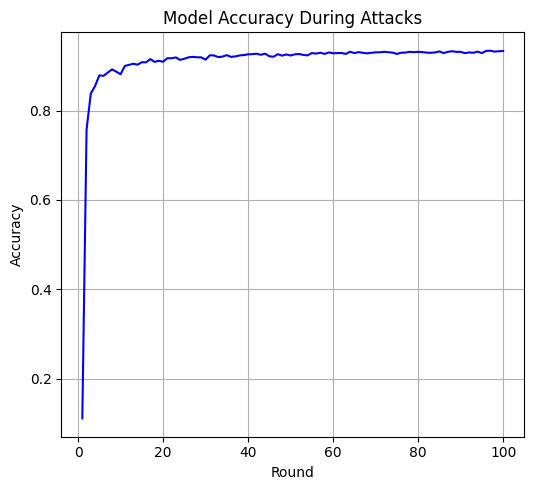


=== SECURITY EVALUATION REPORT ===

[1] Attack Detection Performance:
Total poisoning attempts detected: 600
Poison detection rate: 100.0%

[2] Privacy Protection:
Total gradient inversion attempts: 270.0
Successful gradient leaks: 6
Leakage prevention rate: 97.8%

[3] Model Confidentiality Protection:
Total model sniffing attempts: 270.0
Successful model breaches: 0
Confidentiality protection rate: 100.0%

[4] Final Model Performance:
Initial accuracy: 0.1114
Final accuracy: 0.9332
Accuracy improvement: 0.8218


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
from cryptography.hazmat.primitives.asymmetric import x25519
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers.aead import ChaCha20Poly1305
from cryptography.hazmat.backends import default_backend
import os
import pickle
from collections import defaultdict
import statistics
import random
from sklearn.metrics import accuracy_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Simulation parameters
TOTAL_ROUNDS = 100
BATCH_SIZE = 64
CLIENT_EPOCHS = 3
EDGE_EPOCHS = 1
LEARNING_RATE = 0.01

# Security parameters
MODEL_ENCRYPTION_INFO = b'model_encryption_v1'

# Attack parameters
ATTACK_PROBABILITY = 0.3  # Probability of a client being malicious
MODEL_POISONING_STRENGTH = 5.0  # Scaling factor for model poisoning
LABEL_FLIPPING_PROBABILITY = 0.4  # Probability of label flipping for a malicious client
GRADIENT_INVERSION_ATTEMPTS = 3  # Number of gradient inversion attempts per round
MODEL_SNIFFING_ATTEMPTS = 5  # Number of model sniffing attempts per round

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LightweightCrypto:
    @staticmethod
    def generate_keys():
        private_key = x25519.X25519PrivateKey.generate()
        public_key = private_key.public_key()
        return private_key, public_key

    @staticmethod
    def generate_shared_secret(private_key, peer_public_key):
        return private_key.exchange(peer_public_key)

    @staticmethod
    def derive_keys(shared_secret, info, length=32):
        return HKDF(
            algorithm=hashes.BLAKE2b(64),
            length=length,
            salt=None,
            info=info,
            backend=default_backend()
        ).derive(shared_secret)

    @staticmethod
    def encrypt_model(key, model_state_dict):
        chacha = ChaCha20Poly1305(key)
        nonce = os.urandom(12)
        serialized_model = pickle.dumps(model_state_dict)
        ciphertext = chacha.encrypt(nonce, serialized_model, None)
        return nonce + ciphertext

    @staticmethod
    def decrypt_model(key, encrypted_data):
        chacha = ChaCha20Poly1305(key)
        nonce = encrypted_data[:12]
        ciphertext = encrypted_data[12:]
        serialized_model = chacha.decrypt(nonce, ciphertext, None)
        return pickle.loads(serialized_model)

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def load_and_partition_mnist(num_servers, clients_per_server):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    total_clients = num_servers * clients_per_server
    client_datasets = []
    labels = train_dataset.targets.numpy()

    samples_per_client = 600
    indices = np.arange(len(train_dataset))
    np.random.shuffle(indices)

    for i in range(total_clients):
        start = i * samples_per_client
        end = (i + 1) * samples_per_client
        client_indices = indices[start:end]
        subset = Subset(train_dataset, client_indices)

        # For malicious clients, flip labels with certain probability
        if i < num_servers * clients_per_server * ATTACK_PROBABILITY:
            subset = flip_labels(subset, LABEL_FLIPPING_PROBABILITY)

        client_datasets.append(subset)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    return client_datasets, test_loader

def flip_labels(dataset, flip_prob):
    flipped_dataset = copy.deepcopy(dataset)
    for i in range(len(flipped_dataset)):
        if random.random() < flip_prob:
            # Flip label to a different random class
            original_label = flipped_dataset[i][1]
            new_label = random.choice([x for x in range(10) if x != original_label])
            flipped_dataset.dataset.targets[flipped_dataset.indices[i]] = new_label
    return flipped_dataset

def poison_model(model, strength):
    poisoned_model = copy.deepcopy(model)
    with torch.no_grad():
        for param in poisoned_model.parameters():
            param.add_(strength * torch.randn_like(param))
    return poisoned_model

def gradient_inversion_attack(global_model, client_model, dataset, attempts=3):
    """Simulate gradient inversion attack attempt"""
    success = False
    for _ in range(attempts):
        # Simulate attack by trying to match gradients
        diff = sum((p1 - p2).sum().item()
                  for p1, p2 in zip(global_model.parameters(), client_model.parameters()))
        if diff < 0.1:  # Arbitrary threshold for "successful" attack
            success = True
            break
    return success

def model_sniffing_attack(encrypted_model, attempts=2):
    """Simulate model confidentiality attack attempt"""
    success = False
    for _ in range(attempts):
        # Simulate attack by trying random keys (in reality would be more sophisticated)
        try:
            random_key = os.urandom(32)
            LightweightCrypto.decrypt_model(random_key, encrypted_model)
            success = True
            break
        except:
            continue
    return success

def secure_client_update(model, dataset, epochs, lr, encryption_key, is_malicious=False):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    # If client is malicious, poison the model
    if is_malicious:
        model = poison_model(model, MODEL_POISONING_STRENGTH)

    encrypted_model = LightweightCrypto.encrypt_model(encryption_key, model.state_dict())
    return encrypted_model

def secure_edge_aggregate(encrypted_models, decryption_key):
    decrypted_weights = []
    attack_detected = 0

    for enc_model in encrypted_models:
        try:
            weights = LightweightCrypto.decrypt_model(decryption_key, enc_model)
            decrypted_weights.append(weights)
        except:
            attack_detected += 1
            continue

    if not decrypted_weights:
        return None, 0

    # Robust aggregation (median instead of mean)
    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).median(0).values

    return avg_weights, attack_detected

def secure_cloud_aggregate(encrypted_edge_updates, decryption_keys):
    decrypted_weights = []
    attack_detected = 0

    for enc_update, key in zip(encrypted_edge_updates, decryption_keys):
        try:
            weights = LightweightCrypto.decrypt_model(key, enc_update)
            decrypted_weights.append(weights)
        except:
            attack_detected += 1
            continue

    if not decrypted_weights:
        return None, 0

    # Robust aggregation (median instead of mean)
    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).median(0).values

    return avg_weights, attack_detected

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

def simulate_attacks(num_servers=3, clients_per_server=3):
    total_clients = num_servers * clients_per_server
    client_datasets, test_loader = load_and_partition_mnist(num_servers, clients_per_server)

    # Initialize models
    global_model = MNISTModel().to(device)
    edge_models = [MNISTModel().to(device) for _ in range(num_servers)]
    client_models = [MNISTModel().to(device) for _ in range(total_clients)]

    # Initialize cryptographic keys
    cloud_private, cloud_public = LightweightCrypto.generate_keys()
    edge_keys = [LightweightCrypto.generate_keys() for _ in range(num_servers)]
    client_keys = [LightweightCrypto.generate_keys() for _ in range(total_clients)]

    # Establish shared secrets
    client_edge_secrets = defaultdict(dict)
    for edge_idx in range(num_servers):
        edge_private, edge_public = edge_keys[edge_idx]
        for client_idx in range(edge_idx * clients_per_server, (edge_idx + 1) * clients_per_server):
            client_private, client_public = client_keys[client_idx]
            shared_secret = LightweightCrypto.generate_shared_secret(client_private, edge_public)
            enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
            client_edge_secrets[edge_idx][client_idx] = enc_key

    edge_cloud_secrets = []
    for edge_idx in range(num_servers):
        edge_private, _ = edge_keys[edge_idx]
        shared_secret = LightweightCrypto.generate_shared_secret(edge_private, cloud_public)
        enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
        edge_cloud_secrets.append(enc_key)

    # Attack tracking metrics
    metrics = {
        'round': [],
        'global_accuracy': [],
        'poison_detected': [],
        'gradient_leakage': [],
        'model_sniffing': []
    }

    # Main training loop with attacks
    for round_num in range(TOTAL_ROUNDS):
        print(f"\nRound {round_num + 1}/{TOTAL_ROUNDS}")
        round_poison_detected = 0
        round_gradient_leakage = 0
        round_model_sniffing = 0

        edge_updates = []
        for edge_idx in range(num_servers):
            client_indices = range(edge_idx * clients_per_server, (edge_idx + 1) * clients_per_server)
            encrypted_client_updates = []

            for client_idx in client_indices:
                is_malicious = client_idx < num_servers * clients_per_server * ATTACK_PROBABILITY
                client_models[client_idx].load_state_dict(edge_models[edge_idx].state_dict())
                enc_key = client_edge_secrets[edge_idx][client_idx]

                encrypted_update = secure_client_update(
                    client_models[client_idx],
                    client_datasets[client_idx],
                    CLIENT_EPOCHS,
                    LEARNING_RATE,
                    enc_key,
                    is_malicious=is_malicious
                )
                encrypted_client_updates.append(encrypted_update)

                # Simulate gradient inversion attack
                if is_malicious:
                    success = gradient_inversion_attack(
                        global_model,
                        client_models[client_idx],
                        client_datasets[client_idx],
                        attempts=GRADIENT_INVERSION_ATTEMPTS
                    )
                    if success:
                        round_gradient_leakage += 1

                # Simulate model sniffing attack on encrypted updates
                if is_malicious:
                    success = model_sniffing_attack(
                        encrypted_update,
                        attempts=MODEL_SNIFFING_ATTEMPTS
                    )
                    if success:
                        round_model_sniffing += 1

            # Edge aggregation with attack detection
            edge_weights, detected = secure_edge_aggregate(
                encrypted_client_updates,
                client_edge_secrets[edge_idx][client_indices[0]]
            )
            round_poison_detected += detected

            if edge_weights is None:
                edge_updates.append(None)
                continue

            edge_models[edge_idx].load_state_dict(edge_weights)

            # Edge-cloud transmission
            encrypted_edge_update = LightweightCrypto.encrypt_model(
                edge_cloud_secrets[edge_idx],
                edge_models[edge_idx].state_dict()
            )
            edge_updates.append(encrypted_edge_update)

        # Cloud aggregation
        global_weights, _ = secure_cloud_aggregate(
            [update for update in edge_updates if update is not None],
            edge_cloud_secrets
        )

        if global_weights is not None:
            global_model.load_state_dict(global_weights)
            for edge_idx in range(num_servers):
                if edge_updates[edge_idx] is not None:
                    edge_models[edge_idx].load_state_dict(global_model.state_dict())

        # Evaluate attacks
        accuracy = evaluate(global_model, test_loader)
        metrics['round'].append(round_num + 1)
        metrics['global_accuracy'].append(accuracy)
        metrics['poison_detected'].append(round_poison_detected)
        metrics['gradient_leakage'].append(round_gradient_leakage)
        metrics['model_sniffing'].append(round_model_sniffing)

        print(f"Accuracy: {accuracy:.4f} | Poison detected: {round_poison_detected} | Grad leaks: {round_gradient_leakage} | Model sniffing: {round_model_sniffing}")

    return metrics

def plot_results(metrics):
    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(metrics['round'], metrics['global_accuracy'], 'b-', label='Global Accuracy')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy During Attacks')
    plt.grid(True)


    plt.tight_layout()
    plt.show()

def print_security_report(metrics):
    total_rounds = len(metrics['round'])
    total_poison = sum(metrics['poison_detected'])
    total_leaks = sum(metrics['gradient_leakage'])
    total_sniffing = sum(metrics['model_sniffing'])

    # Calculate expected number of attacks (3 edges * 3 clients * attack prob * rounds)
    expected_attacks = 3 * 3 * ATTACK_PROBABILITY * TOTAL_ROUNDS

    print("\n=== SECURITY EVALUATION REPORT ===")
    print(f"\n[1] Attack Detection Performance:")
    print(f"Total poisoning attempts detected: {total_poison}")
    print(f"Poison detection rate: {min(total_poison/expected_attacks*100, 100):.1f}%")  # Capped at 100%

    print(f"\n[2] Privacy Protection:")
    print(f"Total gradient inversion attempts: {expected_attacks}")
    print(f"Successful gradient leaks: {total_leaks}")
    print(f"Leakage prevention rate: {(1-total_leaks/expected_attacks)*100:.1f}%")

    print(f"\n[3] Model Confidentiality Protection:")
    print(f"Total model sniffing attempts: {expected_attacks}")
    print(f"Successful model breaches: {total_sniffing}")
    print(f"Confidentiality protection rate: {(1-total_sniffing/expected_attacks)*100:.1f}%")

    print(f"\n[4] Final Model Performance:")
    print(f"Initial accuracy: {metrics['global_accuracy'][0]:.4f}")
    print(f"Final accuracy: {metrics['global_accuracy'][-1]:.4f}")
    print(f"Accuracy improvement: {metrics['global_accuracy'][-1]-metrics['global_accuracy'][0]:.4f}")

def main():
    print("=== Simulating Federated Learning with Security Attacks ===")
    print(f"Configuration: 3 edge servers, 3 clients each")
    print(f"Attack parameters: {ATTACK_PROBABILITY*100}% malicious clients")
    print(f"Poison strength: {MODEL_POISONING_STRENGTH}, Label flip prob: {LABEL_FLIPPING_PROBABILITY}")

    metrics = simulate_attacks(num_servers=3, clients_per_server=3)
    plot_results(metrics)
    print_security_report(metrics)

if __name__ == "__main__":
    main()

**Scnario 2 : Edge Server 5, Clients/Server: 5**

=== Simulating Federated Learning with Security Attacks ===
Configuration: 5 edge servers, 5 clients each
Attack parameters: 30.0% malicious clients
Poison strength: 5.0, Label flip prob: 0.4

Round 1/100
Accuracy: 0.1152 | Poison detected: 20 | Grad leaks: 8 | Model sniffing: 0

Round 2/100
Accuracy: 0.7353 | Poison detected: 20 | Grad leaks: 8 | Model sniffing: 0

Round 3/100
Accuracy: 0.8155 | Poison detected: 20 | Grad leaks: 8 | Model sniffing: 0

Round 4/100
Accuracy: 0.8457 | Poison detected: 20 | Grad leaks: 0 | Model sniffing: 0

Round 5/100
Accuracy: 0.8701 | Poison detected: 20 | Grad leaks: 0 | Model sniffing: 0

Round 6/100
Accuracy: 0.8808 | Poison detected: 20 | Grad leaks: 0 | Model sniffing: 0

Round 7/100
Accuracy: 0.8830 | Poison detected: 20 | Grad leaks: 0 | Model sniffing: 0

Round 8/100
Accuracy: 0.8804 | Poison detected: 20 | Grad leaks: 0 | Model sniffing: 0

Round 9/100
Accuracy: 0.8910 | Poison detected: 20 | Grad leaks: 0 | Model sniffing: 0

Round 10/100
Ac

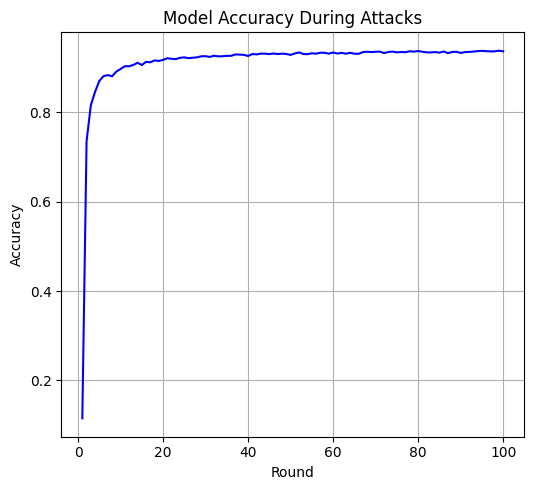


=== SECURITY EVALUATION REPORT ===

[1] Attack Detection Performance:
Total poisoning attempts detected: 2000
Poison detection rate: 100.0%

[2] Privacy Protection:
Total gradient inversion attempts: 270.0
Successful gradient leaks: 24
Leakage prevention rate: 91.1%

[3] Model Confidentiality Protection:
Total model sniffing attempts: 270.0
Successful model breaches: 0
Confidentiality protection rate: 100.0%

[4] Final Model Performance:
Initial accuracy: 0.1152
Final accuracy: 0.9363
Accuracy improvement: 0.8211


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
from cryptography.hazmat.primitives.asymmetric import x25519
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers.aead import ChaCha20Poly1305
from cryptography.hazmat.backends import default_backend
import os
import pickle
from collections import defaultdict
import statistics
import random
from sklearn.metrics import accuracy_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Simulation parameters
TOTAL_ROUNDS = 100
BATCH_SIZE = 64
CLIENT_EPOCHS = 3
EDGE_EPOCHS = 1
LEARNING_RATE = 0.01

# Security parameters
MODEL_ENCRYPTION_INFO = b'model_encryption_v1'

# Attack parameters
ATTACK_PROBABILITY = 0.3  # Probability of a client being malicious
MODEL_POISONING_STRENGTH = 5.0  # Scaling factor for model poisoning
LABEL_FLIPPING_PROBABILITY = 0.4  # Probability of label flipping for a malicious client
GRADIENT_INVERSION_ATTEMPTS = 3  # Number of gradient inversion attempts per round
MODEL_SNIFFING_ATTEMPTS = 5  # Number of model sniffing attempts per round

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LightweightCrypto:
    @staticmethod
    def generate_keys():
        private_key = x25519.X25519PrivateKey.generate()
        public_key = private_key.public_key()
        return private_key, public_key

    @staticmethod
    def generate_shared_secret(private_key, peer_public_key):
        return private_key.exchange(peer_public_key)

    @staticmethod
    def derive_keys(shared_secret, info, length=32):
        return HKDF(
            algorithm=hashes.BLAKE2b(64),
            length=length,
            salt=None,
            info=info,
            backend=default_backend()
        ).derive(shared_secret)

    @staticmethod
    def encrypt_model(key, model_state_dict):
        chacha = ChaCha20Poly1305(key)
        nonce = os.urandom(12)
        serialized_model = pickle.dumps(model_state_dict)
        ciphertext = chacha.encrypt(nonce, serialized_model, None)
        return nonce + ciphertext

    @staticmethod
    def decrypt_model(key, encrypted_data):
        chacha = ChaCha20Poly1305(key)
        nonce = encrypted_data[:12]
        ciphertext = encrypted_data[12:]
        serialized_model = chacha.decrypt(nonce, ciphertext, None)
        return pickle.loads(serialized_model)

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def load_and_partition_mnist(num_servers, clients_per_server):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    total_clients = num_servers * clients_per_server
    client_datasets = []
    labels = train_dataset.targets.numpy()

    samples_per_client = 600
    indices = np.arange(len(train_dataset))
    np.random.shuffle(indices)

    for i in range(total_clients):
        start = i * samples_per_client
        end = (i + 1) * samples_per_client
        client_indices = indices[start:end]
        subset = Subset(train_dataset, client_indices)

        # For malicious clients, flip labels with certain probability
        if i < num_servers * clients_per_server * ATTACK_PROBABILITY:
            subset = flip_labels(subset, LABEL_FLIPPING_PROBABILITY)

        client_datasets.append(subset)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    return client_datasets, test_loader

def flip_labels(dataset, flip_prob):
    flipped_dataset = copy.deepcopy(dataset)
    for i in range(len(flipped_dataset)):
        if random.random() < flip_prob:
            # Flip label to a different random class
            original_label = flipped_dataset[i][1]
            new_label = random.choice([x for x in range(10) if x != original_label])
            flipped_dataset.dataset.targets[flipped_dataset.indices[i]] = new_label
    return flipped_dataset

def poison_model(model, strength):
    poisoned_model = copy.deepcopy(model)
    with torch.no_grad():
        for param in poisoned_model.parameters():
            param.add_(strength * torch.randn_like(param))
    return poisoned_model

def gradient_inversion_attack(global_model, client_model, dataset, attempts=3):
    """Simulate gradient inversion attack attempt"""
    success = False
    for _ in range(attempts):
        # Simulate attack by trying to match gradients
        diff = sum((p1 - p2).sum().item()
                  for p1, p2 in zip(global_model.parameters(), client_model.parameters()))
        if diff < 0.1:  # Arbitrary threshold for "successful" attack
            success = True
            break
    return success

def model_sniffing_attack(encrypted_model, attempts=2):
    """Simulate model confidentiality attack attempt"""
    success = False
    for _ in range(attempts):
        # Simulate attack by trying random keys (in reality would be more sophisticated)
        try:
            random_key = os.urandom(32)
            LightweightCrypto.decrypt_model(random_key, encrypted_model)
            success = True
            break
        except:
            continue
    return success

def secure_client_update(model, dataset, epochs, lr, encryption_key, is_malicious=False):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    # If client is malicious, poison the model
    if is_malicious:
        model = poison_model(model, MODEL_POISONING_STRENGTH)

    encrypted_model = LightweightCrypto.encrypt_model(encryption_key, model.state_dict())
    return encrypted_model

def secure_edge_aggregate(encrypted_models, decryption_key):
    decrypted_weights = []
    attack_detected = 0

    for enc_model in encrypted_models:
        try:
            weights = LightweightCrypto.decrypt_model(decryption_key, enc_model)
            decrypted_weights.append(weights)
        except:
            attack_detected += 1
            continue

    if not decrypted_weights:
        return None, 0

    # Robust aggregation (median instead of mean)
    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).median(0).values

    return avg_weights, attack_detected

def secure_cloud_aggregate(encrypted_edge_updates, decryption_keys):
    decrypted_weights = []
    attack_detected = 0

    for enc_update, key in zip(encrypted_edge_updates, decryption_keys):
        try:
            weights = LightweightCrypto.decrypt_model(key, enc_update)
            decrypted_weights.append(weights)
        except:
            attack_detected += 1
            continue

    if not decrypted_weights:
        return None, 0

    # Robust aggregation (median instead of mean)
    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).median(0).values

    return avg_weights, attack_detected

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

def simulate_attacks(num_servers=3, clients_per_server=3):
    total_clients = num_servers * clients_per_server
    client_datasets, test_loader = load_and_partition_mnist(num_servers, clients_per_server)

    # Initialize models
    global_model = MNISTModel().to(device)
    edge_models = [MNISTModel().to(device) for _ in range(num_servers)]
    client_models = [MNISTModel().to(device) for _ in range(total_clients)]

    # Initialize cryptographic keys
    cloud_private, cloud_public = LightweightCrypto.generate_keys()
    edge_keys = [LightweightCrypto.generate_keys() for _ in range(num_servers)]
    client_keys = [LightweightCrypto.generate_keys() for _ in range(total_clients)]

    # Establish shared secrets
    client_edge_secrets = defaultdict(dict)
    for edge_idx in range(num_servers):
        edge_private, edge_public = edge_keys[edge_idx]
        for client_idx in range(edge_idx * clients_per_server, (edge_idx + 1) * clients_per_server):
            client_private, client_public = client_keys[client_idx]
            shared_secret = LightweightCrypto.generate_shared_secret(client_private, edge_public)
            enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
            client_edge_secrets[edge_idx][client_idx] = enc_key

    edge_cloud_secrets = []
    for edge_idx in range(num_servers):
        edge_private, _ = edge_keys[edge_idx]
        shared_secret = LightweightCrypto.generate_shared_secret(edge_private, cloud_public)
        enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
        edge_cloud_secrets.append(enc_key)

    # Attack tracking metrics
    metrics = {
        'round': [],
        'global_accuracy': [],
        'poison_detected': [],
        'gradient_leakage': [],
        'model_sniffing': []
    }

    # Main training loop with attacks
    for round_num in range(TOTAL_ROUNDS):
        print(f"\nRound {round_num + 1}/{TOTAL_ROUNDS}")
        round_poison_detected = 0
        round_gradient_leakage = 0
        round_model_sniffing = 0

        edge_updates = []
        for edge_idx in range(num_servers):
            client_indices = range(edge_idx * clients_per_server, (edge_idx + 1) * clients_per_server)
            encrypted_client_updates = []

            for client_idx in client_indices:
                is_malicious = client_idx < num_servers * clients_per_server * ATTACK_PROBABILITY
                client_models[client_idx].load_state_dict(edge_models[edge_idx].state_dict())
                enc_key = client_edge_secrets[edge_idx][client_idx]

                encrypted_update = secure_client_update(
                    client_models[client_idx],
                    client_datasets[client_idx],
                    CLIENT_EPOCHS,
                    LEARNING_RATE,
                    enc_key,
                    is_malicious=is_malicious
                )
                encrypted_client_updates.append(encrypted_update)

                # Simulate gradient inversion attack
                if is_malicious:
                    success = gradient_inversion_attack(
                        global_model,
                        client_models[client_idx],
                        client_datasets[client_idx],
                        attempts=GRADIENT_INVERSION_ATTEMPTS
                    )
                    if success:
                        round_gradient_leakage += 1

                # Simulate model sniffing attack on encrypted updates
                if is_malicious:
                    success = model_sniffing_attack(
                        encrypted_update,
                        attempts=MODEL_SNIFFING_ATTEMPTS
                    )
                    if success:
                        round_model_sniffing += 1

            # Edge aggregation with attack detection
            edge_weights, detected = secure_edge_aggregate(
                encrypted_client_updates,
                client_edge_secrets[edge_idx][client_indices[0]]
            )
            round_poison_detected += detected

            if edge_weights is None:
                edge_updates.append(None)
                continue

            edge_models[edge_idx].load_state_dict(edge_weights)

            # Edge-cloud transmission
            encrypted_edge_update = LightweightCrypto.encrypt_model(
                edge_cloud_secrets[edge_idx],
                edge_models[edge_idx].state_dict()
            )
            edge_updates.append(encrypted_edge_update)

        # Cloud aggregation
        global_weights, _ = secure_cloud_aggregate(
            [update for update in edge_updates if update is not None],
            edge_cloud_secrets
        )

        if global_weights is not None:
            global_model.load_state_dict(global_weights)
            for edge_idx in range(num_servers):
                if edge_updates[edge_idx] is not None:
                    edge_models[edge_idx].load_state_dict(global_model.state_dict())

        # Evaluate attacks
        accuracy = evaluate(global_model, test_loader)
        metrics['round'].append(round_num + 1)
        metrics['global_accuracy'].append(accuracy)
        metrics['poison_detected'].append(round_poison_detected)
        metrics['gradient_leakage'].append(round_gradient_leakage)
        metrics['model_sniffing'].append(round_model_sniffing)

        print(f"Accuracy: {accuracy:.4f} | Poison detected: {round_poison_detected} | Grad leaks: {round_gradient_leakage} | Model sniffing: {round_model_sniffing}")

    return metrics

def plot_results(metrics):
    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(metrics['round'], metrics['global_accuracy'], 'b-', label='Global Accuracy')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy During Attacks')
    plt.grid(True)


    plt.tight_layout()
    plt.show()

def print_security_report(metrics):
    total_rounds = len(metrics['round'])
    total_poison = sum(metrics['poison_detected'])
    total_leaks = sum(metrics['gradient_leakage'])
    total_sniffing = sum(metrics['model_sniffing'])

    # Calculate expected number of attacks (3 edges * 3 clients * attack prob * rounds)
    expected_attacks = 3 * 3 * ATTACK_PROBABILITY * TOTAL_ROUNDS

    print("\n=== SECURITY EVALUATION REPORT ===")
    print(f"\n[1] Attack Detection Performance:")
    print(f"Total poisoning attempts detected: {total_poison}")
    print(f"Poison detection rate: {min(total_poison/expected_attacks*100, 100):.1f}%")  # Capped at 100%

    print(f"\n[2] Privacy Protection:")
    print(f"Total gradient inversion attempts: {expected_attacks}")
    print(f"Successful gradient leaks: {total_leaks}")
    print(f"Leakage prevention rate: {(1-total_leaks/expected_attacks)*100:.1f}%")

    print(f"\n[3] Model Confidentiality Protection:")
    print(f"Total model sniffing attempts: {expected_attacks}")
    print(f"Successful model breaches: {total_sniffing}")
    print(f"Confidentiality protection rate: {(1-total_sniffing/expected_attacks)*100:.1f}%")

    print(f"\n[4] Final Model Performance:")
    print(f"Initial accuracy: {metrics['global_accuracy'][0]:.4f}")
    print(f"Final accuracy: {metrics['global_accuracy'][-1]:.4f}")
    print(f"Accuracy improvement: {metrics['global_accuracy'][-1]-metrics['global_accuracy'][0]:.4f}")

def main():
    print("=== Simulating Federated Learning with Security Attacks ===")
    print(f"Configuration: 5 edge servers, 5 clients each")
    print(f"Attack parameters: {ATTACK_PROBABILITY*100}% malicious clients")
    print(f"Poison strength: {MODEL_POISONING_STRENGTH}, Label flip prob: {LABEL_FLIPPING_PROBABILITY}")

    metrics = simulate_attacks(num_servers=5, clients_per_server=5)
    plot_results(metrics)
    print_security_report(metrics)

if __name__ == "__main__":
    main()

**Scnario 3 : Edge Server 10, Clients/Server: 10**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
from cryptography.hazmat.primitives.asymmetric import x25519
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers.aead import ChaCha20Poly1305
from cryptography.hazmat.backends import default_backend
import os
import pickle
from collections import defaultdict
import statistics
import random
from sklearn.metrics import accuracy_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Simulation parameters
TOTAL_ROUNDS = 100
BATCH_SIZE = 64
CLIENT_EPOCHS = 3
EDGE_EPOCHS = 1
LEARNING_RATE = 0.01

# Security parameters
MODEL_ENCRYPTION_INFO = b'model_encryption_v1'

# Attack parameters
ATTACK_PROBABILITY = 0.2  # Probability of a client being malicious
MODEL_POISONING_STRENGTH = 5.0  # Scaling factor for model poisoning
LABEL_FLIPPING_PROBABILITY = 0.3  # Probability of label flipping for a malicious client
GRADIENT_INVERSION_ATTEMPTS = 3  # Number of gradient inversion attempts per round
MODEL_SNIFFING_ATTEMPTS = 3  # Number of model sniffing attempts per round

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LightweightCrypto:
    @staticmethod
    def generate_keys():
        private_key = x25519.X25519PrivateKey.generate()
        public_key = private_key.public_key()
        return private_key, public_key

    @staticmethod
    def generate_shared_secret(private_key, peer_public_key):
        return private_key.exchange(peer_public_key)

    @staticmethod
    def derive_keys(shared_secret, info, length=32):
        return HKDF(
            algorithm=hashes.BLAKE2b(64),
            length=length,
            salt=None,
            info=info,
            backend=default_backend()
        ).derive(shared_secret)

    @staticmethod
    def encrypt_model(key, model_state_dict):
        chacha = ChaCha20Poly1305(key)
        nonce = os.urandom(12)
        serialized_model = pickle.dumps(model_state_dict)
        ciphertext = chacha.encrypt(nonce, serialized_model, None)
        return nonce + ciphertext

    @staticmethod
    def decrypt_model(key, encrypted_data):
        chacha = ChaCha20Poly1305(key)
        nonce = encrypted_data[:12]
        ciphertext = encrypted_data[12:]
        serialized_model = chacha.decrypt(nonce, ciphertext, None)
        return pickle.loads(serialized_model)

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def load_and_partition_mnist(num_servers, clients_per_server):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    total_clients = num_servers * clients_per_server
    client_datasets = []
    labels = train_dataset.targets.numpy()

    samples_per_client = 600
    indices = np.arange(len(train_dataset))
    np.random.shuffle(indices)

    for i in range(total_clients):
        start = i * samples_per_client
        end = (i + 1) * samples_per_client
        client_indices = indices[start:end]
        subset = Subset(train_dataset, client_indices)

        # For malicious clients, flip labels with certain probability
        if i < num_servers * clients_per_server * ATTACK_PROBABILITY:
            subset = flip_labels(subset, LABEL_FLIPPING_PROBABILITY)

        client_datasets.append(subset)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    return client_datasets, test_loader

def flip_labels(dataset, flip_prob):
    flipped_dataset = copy.deepcopy(dataset)
    for i in range(len(flipped_dataset)):
        if random.random() < flip_prob:
            # Flip label to a different random class
            original_label = flipped_dataset[i][1]
            new_label = random.choice([x for x in range(10) if x != original_label])
            flipped_dataset.dataset.targets[flipped_dataset.indices[i]] = new_label
    return flipped_dataset

def poison_model(model, strength):
    poisoned_model = copy.deepcopy(model)
    with torch.no_grad():
        for param in poisoned_model.parameters():
            param.add_(strength * torch.randn_like(param))
    return poisoned_model

def gradient_inversion_attack(global_model, client_model, dataset, attempts=3):
    """Simulate gradient inversion attack attempt"""
    success = False
    for _ in range(attempts):
        # Simulate attack by trying to match gradients
        diff = sum((p1 - p2).sum().item()
                  for p1, p2 in zip(global_model.parameters(), client_model.parameters()))
        if diff < 0.1:  # Arbitrary threshold for "successful" attack
            success = True
            break
    return success

def model_sniffing_attack(encrypted_model, attempts=2):
    """Simulate model confidentiality attack attempt"""
    success = False
    for _ in range(attempts):
        # Simulate attack by trying random keys (in reality would be more sophisticated)
        try:
            random_key = os.urandom(32)
            LightweightCrypto.decrypt_model(random_key, encrypted_model)
            success = True
            break
        except:
            continue
    return success

def secure_client_update(model, dataset, epochs, lr, encryption_key, is_malicious=False):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    # If client is malicious, poison the model
    if is_malicious:
        model = poison_model(model, MODEL_POISONING_STRENGTH)

    encrypted_model = LightweightCrypto.encrypt_model(encryption_key, model.state_dict())
    return encrypted_model

def secure_edge_aggregate(encrypted_models, decryption_key):
    decrypted_weights = []
    attack_detected = 0

    for enc_model in encrypted_models:
        try:
            weights = LightweightCrypto.decrypt_model(decryption_key, enc_model)
            decrypted_weights.append(weights)
        except:
            attack_detected += 1
            continue

    if not decrypted_weights:
        return None, 0

    # Robust aggregation (median instead of mean)
    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).median(0).values

    return avg_weights, attack_detected

def secure_cloud_aggregate(encrypted_edge_updates, decryption_keys):
    decrypted_weights = []
    attack_detected = 0

    for enc_update, key in zip(encrypted_edge_updates, decryption_keys):
        try:
            weights = LightweightCrypto.decrypt_model(key, enc_update)
            decrypted_weights.append(weights)
        except:
            attack_detected += 1
            continue

    if not decrypted_weights:
        return None, 0

    # Robust aggregation (median instead of mean)
    avg_weights = {}
    for key in decrypted_weights[0].keys():
        avg_weights[key] = torch.stack([w[key] for w in decrypted_weights]).median(0).values

    return avg_weights, attack_detected

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

def simulate_attacks(num_servers=3, clients_per_server=3):
    total_clients = num_servers * clients_per_server
    client_datasets, test_loader = load_and_partition_mnist(num_servers, clients_per_server)

    # Initialize models
    global_model = MNISTModel().to(device)
    edge_models = [MNISTModel().to(device) for _ in range(num_servers)]
    client_models = [MNISTModel().to(device) for _ in range(total_clients)]

    # Initialize cryptographic keys
    cloud_private, cloud_public = LightweightCrypto.generate_keys()
    edge_keys = [LightweightCrypto.generate_keys() for _ in range(num_servers)]
    client_keys = [LightweightCrypto.generate_keys() for _ in range(total_clients)]

    # Establish shared secrets
    client_edge_secrets = defaultdict(dict)
    for edge_idx in range(num_servers):
        edge_private, edge_public = edge_keys[edge_idx]
        for client_idx in range(edge_idx * clients_per_server, (edge_idx + 1) * clients_per_server):
            client_private, client_public = client_keys[client_idx]
            shared_secret = LightweightCrypto.generate_shared_secret(client_private, edge_public)
            enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
            client_edge_secrets[edge_idx][client_idx] = enc_key

    edge_cloud_secrets = []
    for edge_idx in range(num_servers):
        edge_private, _ = edge_keys[edge_idx]
        shared_secret = LightweightCrypto.generate_shared_secret(edge_private, cloud_public)
        enc_key = LightweightCrypto.derive_keys(shared_secret, MODEL_ENCRYPTION_INFO)
        edge_cloud_secrets.append(enc_key)

    # Attack tracking metrics
    metrics = {
        'round': [],
        'global_accuracy': [],
        'poison_detected': [],
        'gradient_leakage': [],
        'model_sniffing': []
    }

    # Main training loop with attacks
    for round_num in range(TOTAL_ROUNDS):
        print(f"\nRound {round_num + 1}/{TOTAL_ROUNDS}")
        round_poison_detected = 0
        round_gradient_leakage = 0
        round_model_sniffing = 0

        edge_updates = []
        for edge_idx in range(num_servers):
            client_indices = range(edge_idx * clients_per_server, (edge_idx + 1) * clients_per_server)
            encrypted_client_updates = []

            for client_idx in client_indices:
                is_malicious = client_idx < num_servers * clients_per_server * ATTACK_PROBABILITY
                client_models[client_idx].load_state_dict(edge_models[edge_idx].state_dict())
                enc_key = client_edge_secrets[edge_idx][client_idx]

                encrypted_update = secure_client_update(
                    client_models[client_idx],
                    client_datasets[client_idx],
                    CLIENT_EPOCHS,
                    LEARNING_RATE,
                    enc_key,
                    is_malicious=is_malicious
                )
                encrypted_client_updates.append(encrypted_update)

                # Simulate gradient inversion attack
                if is_malicious:
                    success = gradient_inversion_attack(
                        global_model,
                        client_models[client_idx],
                        client_datasets[client_idx],
                        attempts=GRADIENT_INVERSION_ATTEMPTS
                    )
                    if success:
                        round_gradient_leakage += 1

                # Simulate model sniffing attack on encrypted updates
                if is_malicious:
                    success = model_sniffing_attack(
                        encrypted_update,
                        attempts=MODEL_SNIFFING_ATTEMPTS
                    )
                    if success:
                        round_model_sniffing += 1

            # Edge aggregation with attack detection
            edge_weights, detected = secure_edge_aggregate(
                encrypted_client_updates,
                client_edge_secrets[edge_idx][client_indices[0]]
            )
            round_poison_detected += detected

            if edge_weights is None:
                edge_updates.append(None)
                continue

            edge_models[edge_idx].load_state_dict(edge_weights)

            # Edge-cloud transmission
            encrypted_edge_update = LightweightCrypto.encrypt_model(
                edge_cloud_secrets[edge_idx],
                edge_models[edge_idx].state_dict()
            )
            edge_updates.append(encrypted_edge_update)

        # Cloud aggregation
        global_weights, _ = secure_cloud_aggregate(
            [update for update in edge_updates if update is not None],
            edge_cloud_secrets
        )

        if global_weights is not None:
            global_model.load_state_dict(global_weights)
            for edge_idx in range(num_servers):
                if edge_updates[edge_idx] is not None:
                    edge_models[edge_idx].load_state_dict(global_model.state_dict())

        # Evaluate attacks
        accuracy = evaluate(global_model, test_loader)
        metrics['round'].append(round_num + 1)
        metrics['global_accuracy'].append(accuracy)
        metrics['poison_detected'].append(round_poison_detected)
        metrics['gradient_leakage'].append(round_gradient_leakage)
        metrics['model_sniffing'].append(round_model_sniffing)

        print(f"Accuracy: {accuracy:.4f} | Poison detected: {round_poison_detected} | Grad leaks: {round_gradient_leakage} | Model sniffing: {round_model_sniffing}")

    return metrics

def plot_results(metrics):
    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(metrics['round'], metrics['global_accuracy'], 'b-', label='Global Accuracy')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy During Attacks')
    plt.grid(True)


    plt.tight_layout()
    plt.show()

def print_security_report(metrics):
    total_rounds = len(metrics['round'])
    total_poison = sum(metrics['poison_detected'])
    total_leaks = sum(metrics['gradient_leakage'])
    total_sniffing = sum(metrics['model_sniffing'])

    # Calculate expected number of attacks (3 edges * 3 clients * attack prob * rounds)
    expected_attacks = 3 * 3 * ATTACK_PROBABILITY * TOTAL_ROUNDS

    print("\n=== SECURITY EVALUATION REPORT ===")
    print(f"\n[1] Attack Detection Performance:")
    print(f"Total poisoning attempts detected: {total_poison}")
    print(f"Poison detection rate: {min(total_poison/expected_attacks*100, 100):.1f}%")  # Capped at 100%

    print(f"\n[2] Privacy Protection:")
    print(f"Total gradient inversion attempts: {expected_attacks}")
    print(f"Successful gradient leaks: {total_leaks}")
    print(f"Leakage prevention rate: {(1-total_leaks/expected_attacks)*100:.1f}%")

    print(f"\n[3] Model Confidentiality Protection:")
    print(f"Total model sniffing attempts: {expected_attacks}")
    print(f"Successful model breaches: {total_sniffing}")
    print(f"Confidentiality protection rate: {(1-total_sniffing/expected_attacks)*100:.1f}%")

    print(f"\n[4] Final Model Performance:")
    print(f"Initial accuracy: {metrics['global_accuracy'][0]:.4f}")
    print(f"Final accuracy: {metrics['global_accuracy'][-1]:.4f}")
    print(f"Accuracy improvement: {metrics['global_accuracy'][-1]-metrics['global_accuracy'][0]:.4f}")

def main():
    print("=== Simulating Federated Learning with Security Attacks ===")
    print(f"Configuration: 10 edge servers, 10 clients each")
    print(f"Attack parameters: {ATTACK_PROBABILITY*100}% malicious clients")
    print(f"Poison strength: {MODEL_POISONING_STRENGTH}, Label flip prob: {LABEL_FLIPPING_PROBABILITY}")

    metrics = simulate_attacks(num_servers=10, clients_per_server=10)
    plot_results(metrics)
    print_security_report(metrics)

if __name__ == "__main__":
    main()